In [1]:
from preprocessing_ import *
from train_evaluate import *
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np

# Data Setup

## Load Data

In [2]:
data_dir = ''
X_train_valid, y_train_valid, X_test, y_test = load_data(data_dir, subjects=[1,2,3,4,5,6,7,8,9]) # default subjects=[1,2,3,4,5,6,7,8,9]

## Preprocessing

In [3]:
x_train, y_train, x_valid, y_valid, x_test, y_test = main_prep(X_train_valid,y_train_valid,X_test, y_test,2,2,True)
_, y_train =y_train.max(dim=1) 
_, y_valid =y_valid.max(dim=1) 
_, y_test =y_test.max(dim=1) 

Shape of x_train: (6768, 250, 1, 22)
Shape of x_valid: (1692, 250, 1, 22)
Shape of x_test: (1772, 250, 1, 22)
Shape of y_train: torch.Size([6768, 4])
Shape of y_valid: torch.Size([1692, 4])
Shape of y_test: torch.Size([1772, 4])


## PyTorch Dataloaders

In [4]:
data_loaders  = dataloader_setup(x_train, y_train, x_valid, y_valid, x_test, y_test, batch_size=32)

## Parameters

In [5]:
LR      = 0.0005
BETAS   = (0.9, 0.999)
EPS     = 1e-08
DECAY   = 0.0005

BATCH_SIZE = 32
EPOCHS  = 100

# Modeling (CNN, LSTM, GRU, CNN+LSTM, CNN+GRU)

## Models

In [6]:
# # Building the CNN model using sequential class
class CNN(nn.Module):
    # initializers
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(22, 25, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool1 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(25)
        self.dropout = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(25, 50, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool2 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(50, 100, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool3 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(100, 200, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool4 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn4 = nn.BatchNorm2d(200)
        
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(800,4)
        
    # forward method
    def forward(self, input):  #input(22,250,1)
        x = input.permute(0,1,3,2)
        x = self.dropout(self.bn1(self.pool1(F.elu(self.conv1(x)))))
        x = self.dropout(self.bn2(self.pool2(F.elu(self.conv2(x)))))
        x = self.dropout(self.bn3(self.pool3(F.elu(self.conv3(x)))))
        x = self.dropout(self.bn4(self.pool4(F.elu(self.conv4(x)))))
        x = self.flatten(x)
        out = self.dense(x) 
        return out
    
class LSTM(nn.Module):
    
    def __init__(self):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(22, 64, 3, batch_first=True, dropout=0.4)

        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x, h=None):

        # LSTM
        N, C, H, W = x.size()
        x = x.view(N, C, W).permute(0, 2, 1)
        out, _ = self.lstm(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out

class GRU(nn.Module):
    
    def __init__(self):
        super(GRU, self).__init__()

        self.gru = nn.GRU(22, 64, 3, batch_first=True, dropout=0.4)

        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x, h=None):

        # GRU
        N, C, H, W = x.size()
        x = x.view(N, C, W).permute(0, 2, 1)
        out, _ = self.gru(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out
    
class Permute(nn.Module):
    def forward(self, x):
        return x.permute(0, 2, 1, 3)
    
class CNN_LSTM(nn.Module):
    
    def __init__(self):
        super(CNN_LSTM, self).__init__()

        self.conv1 = nn.Conv2d(22, 25, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool1 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(25)
        self.dropout = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(25, 50, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool2 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(50, 100, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool3 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(100, 200, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool4 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn4 = nn.BatchNorm2d(200)
        
        
        
        self.lstm = nn.LSTM(4, 64, 3, batch_first=True, dropout=0.4)
        
        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x):
        
        # CNN
        x = x.permute(0,1,3,2)
        x = self.dropout(self.bn1(self.pool1(F.elu(self.conv1(x)))))
        x = self.dropout(self.bn2(self.pool2(F.elu(self.conv2(x)))))
        x = self.dropout(self.bn3(self.pool3(F.elu(self.conv3(x)))))
        x = self.dropout(self.bn4(self.pool4(F.elu(self.conv4(x)))))

        # LSTM
        N, C, H, W = x.size()
        x = x.view(N, C, H).permute(0, 1, 2)
        out, _ = self.lstm(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out
    
class CNN_GRU(nn.Module):
    def __init__(self):
        super(CNN_GRU, self).__init__()

        self.conv1 = nn.Conv2d(22, 25, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool1 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(25)
        self.dropout = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(25, 50, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool2 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(50, 100, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool3 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(100, 200, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool4 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn4 = nn.BatchNorm2d(200)
        
        self.gru = nn.GRU(4, 64, 3, batch_first=True, dropout=0.4)
        
        self.fc = nn.Sequential(
            nn.Linear(64, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
    
    def forward(self, x):

        # CNN
        x = x.permute(0,1,3,2)
        x = self.dropout(self.bn1(self.pool1(F.elu(self.conv1(x)))))
        x = self.dropout(self.bn2(self.pool2(F.elu(self.conv2(x)))))
        x = self.dropout(self.bn3(self.pool3(F.elu(self.conv3(x)))))
        x = self.dropout(self.bn4(self.pool4(F.elu(self.conv4(x)))))

        # GRU
        N, C, H, W = x.size()
        x = x.view(N, C, H).permute(0, 1, 2)
        out, _ = self.gru(x)

        # Fully Connected Layer
        out = self.fc(out[:, -1, :])

        return out

## Initiate models

In [7]:
# initiate CNN model
cnn = CNN()
# create your cnn optimizer
cnn_optimizer = optim.Adam(cnn.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate LSTM model
lstm = LSTM()
# create your lstm optimizer
lstm_optimizer = optim.Adam(lstm.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate GRU model
gru = GRU()
# create your gru optimizer
gru_optimizer = optim.Adam(gru.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate CNN_LSTM model
cnn_lstm = CNN_LSTM()
# create your cnn_lstm optimizer
cnn_lstm_optimizer = optim.Adam(cnn_lstm.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

# initiate CNN_GRU model
cnn_gru = CNN_GRU()
# create your cnn_gru optimizer
cnn_gru_optimizer = optim.Adam(cnn_gru.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=DECAY)

## CNN

In [ ]:
train_and_evaluate(cnn, cnn_optimizer, data_loaders, num_epochs=EPOCHS)

## LSTM

In [ ]:
train_and_evaluate(lstm, lstm_optimizer, data_loaders, num_epochs=EPOCHS)

## GRU

In [ ]:
train_and_evaluate(gru, gru_optimizer, data_loaders, num_epochs=EPOCHS)

## CNN+LSTM

In [ ]:
train_and_evaluate(cnn_lstm, cnn_lstm_optimizer, data_loaders, num_epochs=EPOCHS)

## CNN+GRU

In [ ]:
train_and_evaluate(cnn_gru, cnn_gru_optimizer, data_loaders, num_epochs=EPOCHS)

# GAN Data Augmentation

In [9]:
fake_WGAN = np.load('WGAN_generate_X.npy')
fake_label = np.load('generate_label.npy')

fake_WGAN = np.swapaxes(fake_WGAN, 1,2)
fake_WGAN = np.swapaxes(fake_WGAN,2,3)

fake_label = torch.tensor(fake_label).to(torch.int64)
fake_label = torch.argmax(fake_label, -1)
fake_label = fake_label.numpy()
fake_label = torch.LongTensor(fake_label).to(torch.int64)


#Add 8460/4 fake data
x_train_plus_WGAN = np.vstack((x_train, fake_WGAN[0:fake_WGAN.shape[0]//4]))
y_train_plus_WGAN = np.hstack((y_train, fake_label[0:fake_WGAN.shape[0]//4]))
p = np.random.permutation(x_train_plus_WGAN.shape[0])
x_train_plus_WGAN, y_train_plus_WGAN = x_train_plus_WGAN[p], y_train_plus_WGAN[p]

In [10]:
data_loaders_wgan = dataloader_setup(x_train_plus_WGAN, y_train_plus_WGAN, x_valid, y_valid, x_test, y_test, batch_size=32)

In [11]:
fake_ACGAN = np.load('ACGAN_generate_X.npy')
fake_label = np.load('generate_label.npy')

fake_ACGAN = np.swapaxes(fake_ACGAN, 1,2)
fake_ACGAN = np.swapaxes(fake_ACGAN,2,3)

fake_label = torch.tensor(fake_label).to(torch.int64)
fake_label = torch.argmax(fake_label, -1)
fake_label = fake_label.numpy()
fake_label = torch.LongTensor(fake_label).to(torch.int64) 

#Add 8460/4 fake data
x_train_plus_ACGAN = np.vstack((x_train, fake_WGAN[0:fake_ACGAN.shape[0]//4]))
y_train_plus_ACGAN = np.hstack((y_train, fake_label[0:fake_ACGAN.shape[0]//4]))
p = np.random.permutation(x_train_plus_ACGAN.shape[0])
x_train_plus_ACGAN, y_train_plus_ACGAN = x_train_plus_ACGAN[p], y_train_plus_ACGAN[p]

In [12]:
data_loaders_acgan = dataloader_setup(x_train_plus_ACGAN, y_train_plus_ACGAN, x_valid, y_valid, x_test, y_test, batch_size=32)

# ACGAN

## CNN

In [ ]:
train_and_evaluate(cnn, cnn_optimizer, data_loaders_acgan, num_epochs=EPOCHS)

## LSTM

In [ ]:
train_and_evaluate(lstm, lstm_optimizer, data_loaders_acgan, num_epochs=EPOCHS)

## GRU

In [ ]:
train_and_evaluate(gru, gru_optimizer, data_loaders_acgan, num_epochs=EPOCHS)

## CNN+LSTM

In [ ]:
train_and_evaluate(cnn_lstm, cnn_lstm_optimizer, data_loaders_acgan, num_epochs=EPOCHS)

## CNN+GRU

In [ ]:
train_and_evaluate(cnn_gru, cnn_gru_optimizer, data_loaders_acgan, num_epochs=EPOCHS)

# WGAN

## CNN

Training Progress: 	Epoch 1 [0/8883 (0.00%)]		Loss: 1.65029
Training Progress: 	Epoch 1 [320/8883 (3.60%)]		Loss: 1.68599
Training Progress: 	Epoch 1 [640/8883 (7.19%)]		Loss: 1.46664
Training Progress: 	Epoch 1 [960/8883 (10.79%)]		Loss: 1.56269
Training Progress: 	Epoch 1 [1280/8883 (14.39%)]		Loss: 1.50588
Training Progress: 	Epoch 1 [1600/8883 (17.99%)]		Loss: 1.67049
Training Progress: 	Epoch 1 [1920/8883 (21.58%)]		Loss: 1.44089
Training Progress: 	Epoch 1 [2240/8883 (25.18%)]		Loss: 1.57890
Training Progress: 	Epoch 1 [2560/8883 (28.78%)]		Loss: 1.49102
Training Progress: 	Epoch 1 [2880/8883 (32.37%)]		Loss: 1.59067
Training Progress: 	Epoch 1 [3200/8883 (35.97%)]		Loss: 1.52617
Training Progress: 	Epoch 1 [3520/8883 (39.57%)]		Loss: 1.43644
Training Progress: 	Epoch 1 [3840/8883 (43.17%)]		Loss: 1.48197
Training Progress: 	Epoch 1 [4160/8883 (46.76%)]		Loss: 1.60653
Training Progress: 	Epoch 1 [4480/8883 (50.36%)]		Loss: 1.43721
Training Progress: 	Epoch 1 [4800/8883 (53.96%)]	

Training Progress: 	Epoch 5 [2240/8883 (25.18%)]		Loss: 1.18928
Training Progress: 	Epoch 5 [2560/8883 (28.78%)]		Loss: 1.16394
Training Progress: 	Epoch 5 [2880/8883 (32.37%)]		Loss: 1.10341
Training Progress: 	Epoch 5 [3200/8883 (35.97%)]		Loss: 1.33387
Training Progress: 	Epoch 5 [3520/8883 (39.57%)]		Loss: 1.18658
Training Progress: 	Epoch 5 [3840/8883 (43.17%)]		Loss: 1.29155
Training Progress: 	Epoch 5 [4160/8883 (46.76%)]		Loss: 1.19504
Training Progress: 	Epoch 5 [4480/8883 (50.36%)]		Loss: 1.02439
Training Progress: 	Epoch 5 [4800/8883 (53.96%)]		Loss: 1.16354
Training Progress: 	Epoch 5 [5120/8883 (57.55%)]		Loss: 1.31042
Training Progress: 	Epoch 5 [5440/8883 (61.15%)]		Loss: 1.25251
Training Progress: 	Epoch 5 [5760/8883 (64.75%)]		Loss: 1.22860
Training Progress: 	Epoch 5 [6080/8883 (68.35%)]		Loss: 1.05840
Training Progress: 	Epoch 5 [6400/8883 (71.94%)]		Loss: 1.06054
Training Progress: 	Epoch 5 [6720/8883 (75.54%)]		Loss: 1.03263
Training Progress: 	Epoch 5 [7040/8883 (

Training Progress: 	Epoch 9 [4480/8883 (50.36%)]		Loss: 1.05040
Training Progress: 	Epoch 9 [4800/8883 (53.96%)]		Loss: 1.24077
Training Progress: 	Epoch 9 [5120/8883 (57.55%)]		Loss: 1.11539
Training Progress: 	Epoch 9 [5440/8883 (61.15%)]		Loss: 1.04403
Training Progress: 	Epoch 9 [5760/8883 (64.75%)]		Loss: 0.99431
Training Progress: 	Epoch 9 [6080/8883 (68.35%)]		Loss: 0.78399
Training Progress: 	Epoch 9 [6400/8883 (71.94%)]		Loss: 1.02036
Training Progress: 	Epoch 9 [6720/8883 (75.54%)]		Loss: 1.18321
Training Progress: 	Epoch 9 [7040/8883 (79.14%)]		Loss: 1.05007
Training Progress: 	Epoch 9 [7360/8883 (82.73%)]		Loss: 0.95355
Training Progress: 	Epoch 9 [7680/8883 (86.33%)]		Loss: 0.87961
Training Progress: 	Epoch 9 [8000/8883 (89.93%)]		Loss: 1.11242
Training Progress: 	Epoch 9 [8320/8883 (93.53%)]		Loss: 0.93612
Training Progress: 	Epoch 9 [8640/8883 (97.12%)]		Loss: 1.11541
	Train loss: 0.02891, Accuracy: 5308/8883 (59.00%)
	Validation loss: 0.00050, Accuracy: 1140/1692 (67.00

Training Progress: 	Epoch 13 [6400/8883 (71.94%)]		Loss: 0.90076
Training Progress: 	Epoch 13 [6720/8883 (75.54%)]		Loss: 1.12802
Training Progress: 	Epoch 13 [7040/8883 (79.14%)]		Loss: 1.05834
Training Progress: 	Epoch 13 [7360/8883 (82.73%)]		Loss: 0.96369
Training Progress: 	Epoch 13 [7680/8883 (86.33%)]		Loss: 0.60401
Training Progress: 	Epoch 13 [8000/8883 (89.93%)]		Loss: 1.02245
Training Progress: 	Epoch 13 [8320/8883 (93.53%)]		Loss: 0.87289
Training Progress: 	Epoch 13 [8640/8883 (97.12%)]		Loss: 1.02550
	Train loss: 0.02398, Accuracy: 6037/8883 (67.00%)
	Validation loss: 0.00039, Accuracy: 1307/1692 (77.00%)
	Test loss: 0.00050, Accuracy: 1156/1772 (65.00%)

Training Progress: 	Epoch 14 [0/8883 (0.00%)]		Loss: 1.05018
Training Progress: 	Epoch 14 [320/8883 (3.60%)]		Loss: 1.06244
Training Progress: 	Epoch 14 [640/8883 (7.19%)]		Loss: 0.89847
Training Progress: 	Epoch 14 [960/8883 (10.79%)]		Loss: 1.09929
Training Progress: 	Epoch 14 [1280/8883 (14.39%)]		Loss: 1.05187
Traini

Training Progress: 	Epoch 17 [8000/8883 (89.93%)]		Loss: 0.86771
Training Progress: 	Epoch 17 [8320/8883 (93.53%)]		Loss: 0.89622
Training Progress: 	Epoch 17 [8640/8883 (97.12%)]		Loss: 0.94149
	Train loss: 0.02166, Accuracy: 6347/8883 (71.00%)
	Validation loss: 0.00033, Accuracy: 1387/1692 (81.00%)
	Test loss: 0.00050, Accuracy: 1152/1772 (65.00%)

Training Progress: 	Epoch 18 [0/8883 (0.00%)]		Loss: 1.14399
Training Progress: 	Epoch 18 [320/8883 (3.60%)]		Loss: 0.85151
Training Progress: 	Epoch 18 [640/8883 (7.19%)]		Loss: 0.75566
Training Progress: 	Epoch 18 [960/8883 (10.79%)]		Loss: 0.93781
Training Progress: 	Epoch 18 [1280/8883 (14.39%)]		Loss: 1.02634
Training Progress: 	Epoch 18 [1600/8883 (17.99%)]		Loss: 0.64440
Training Progress: 	Epoch 18 [1920/8883 (21.58%)]		Loss: 0.77451
Training Progress: 	Epoch 18 [2240/8883 (25.18%)]		Loss: 0.74677
Training Progress: 	Epoch 18 [2560/8883 (28.78%)]		Loss: 1.01443
Training Progress: 	Epoch 18 [2880/8883 (32.37%)]		Loss: 0.92104
Traini

Training Progress: 	Epoch 22 [320/8883 (3.60%)]		Loss: 0.79987
Training Progress: 	Epoch 22 [640/8883 (7.19%)]		Loss: 0.69944
Training Progress: 	Epoch 22 [960/8883 (10.79%)]		Loss: 0.85637
Training Progress: 	Epoch 22 [1280/8883 (14.39%)]		Loss: 0.89874
Training Progress: 	Epoch 22 [1600/8883 (17.99%)]		Loss: 0.66763
Training Progress: 	Epoch 22 [1920/8883 (21.58%)]		Loss: 0.73059
Training Progress: 	Epoch 22 [2240/8883 (25.18%)]		Loss: 0.71039
Training Progress: 	Epoch 22 [2560/8883 (28.78%)]		Loss: 0.73954
Training Progress: 	Epoch 22 [2880/8883 (32.37%)]		Loss: 0.95304
Training Progress: 	Epoch 22 [3200/8883 (35.97%)]		Loss: 0.95588
Training Progress: 	Epoch 22 [3520/8883 (39.57%)]		Loss: 1.07958
Training Progress: 	Epoch 22 [3840/8883 (43.17%)]		Loss: 1.01787
Training Progress: 	Epoch 22 [4160/8883 (46.76%)]		Loss: 0.97541
Training Progress: 	Epoch 22 [4480/8883 (50.36%)]		Loss: 0.77154
Training Progress: 	Epoch 22 [4800/8883 (53.96%)]		Loss: 0.74000
Training Progress: 	Epoch 22 [

Training Progress: 	Epoch 26 [1920/8883 (21.58%)]		Loss: 0.57113
Training Progress: 	Epoch 26 [2240/8883 (25.18%)]		Loss: 0.62379
Training Progress: 	Epoch 26 [2560/8883 (28.78%)]		Loss: 0.83838
Training Progress: 	Epoch 26 [2880/8883 (32.37%)]		Loss: 0.90652
Training Progress: 	Epoch 26 [3200/8883 (35.97%)]		Loss: 0.70324
Training Progress: 	Epoch 26 [3520/8883 (39.57%)]		Loss: 1.00560
Training Progress: 	Epoch 26 [3840/8883 (43.17%)]		Loss: 0.97121
Training Progress: 	Epoch 26 [4160/8883 (46.76%)]		Loss: 0.65909
Training Progress: 	Epoch 26 [4480/8883 (50.36%)]		Loss: 0.63335
Training Progress: 	Epoch 26 [4800/8883 (53.96%)]		Loss: 0.70535
Training Progress: 	Epoch 26 [5120/8883 (57.55%)]		Loss: 0.71117
Training Progress: 	Epoch 26 [5440/8883 (61.15%)]		Loss: 0.76331
Training Progress: 	Epoch 26 [5760/8883 (64.75%)]		Loss: 0.69438
Training Progress: 	Epoch 26 [6080/8883 (68.35%)]		Loss: 0.86239
Training Progress: 	Epoch 26 [6400/8883 (71.94%)]		Loss: 0.82817
Training Progress: 	Epoch

Training Progress: 	Epoch 30 [3520/8883 (39.57%)]		Loss: 0.98650
Training Progress: 	Epoch 30 [3840/8883 (43.17%)]		Loss: 0.73376
Training Progress: 	Epoch 30 [4160/8883 (46.76%)]		Loss: 0.64017
Training Progress: 	Epoch 30 [4480/8883 (50.36%)]		Loss: 0.69275
Training Progress: 	Epoch 30 [4800/8883 (53.96%)]		Loss: 0.63717
Training Progress: 	Epoch 30 [5120/8883 (57.55%)]		Loss: 0.94647
Training Progress: 	Epoch 30 [5440/8883 (61.15%)]		Loss: 0.73380
Training Progress: 	Epoch 30 [5760/8883 (64.75%)]		Loss: 0.72188
Training Progress: 	Epoch 30 [6080/8883 (68.35%)]		Loss: 0.71820
Training Progress: 	Epoch 30 [6400/8883 (71.94%)]		Loss: 0.59096
Training Progress: 	Epoch 30 [6720/8883 (75.54%)]		Loss: 0.81874
Training Progress: 	Epoch 30 [7040/8883 (79.14%)]		Loss: 1.02567
Training Progress: 	Epoch 30 [7360/8883 (82.73%)]		Loss: 0.78435
Training Progress: 	Epoch 30 [7680/8883 (86.33%)]		Loss: 0.58855
Training Progress: 	Epoch 30 [8000/8883 (89.93%)]		Loss: 0.82672
Training Progress: 	Epoch

Training Progress: 	Epoch 34 [5120/8883 (57.55%)]		Loss: 0.76504
Training Progress: 	Epoch 34 [5440/8883 (61.15%)]		Loss: 0.75829
Training Progress: 	Epoch 34 [5760/8883 (64.75%)]		Loss: 0.62360
Training Progress: 	Epoch 34 [6080/8883 (68.35%)]		Loss: 0.81703
Training Progress: 	Epoch 34 [6400/8883 (71.94%)]		Loss: 0.78781
Training Progress: 	Epoch 34 [6720/8883 (75.54%)]		Loss: 0.90745
Training Progress: 	Epoch 34 [7040/8883 (79.14%)]		Loss: 0.86245
Training Progress: 	Epoch 34 [7360/8883 (82.73%)]		Loss: 0.74063
Training Progress: 	Epoch 34 [7680/8883 (86.33%)]		Loss: 0.57103
Training Progress: 	Epoch 34 [8000/8883 (89.93%)]		Loss: 0.69908
Training Progress: 	Epoch 34 [8320/8883 (93.53%)]		Loss: 0.73008
Training Progress: 	Epoch 34 [8640/8883 (97.12%)]		Loss: 0.86860
	Train loss: 0.01497, Accuracy: 7073/8883 (79.00%)
	Validation loss: 0.00018, Accuracy: 1567/1692 (92.00%)
	Test loss: 0.00055, Accuracy: 1133/1772 (63.00%)

Training Progress: 	Epoch 35 [0/8883 (0.00%)]		Loss: 0.92629
T

Training Progress: 	Epoch 38 [6720/8883 (75.54%)]		Loss: 0.81770
Training Progress: 	Epoch 38 [7040/8883 (79.14%)]		Loss: 0.79504
Training Progress: 	Epoch 38 [7360/8883 (82.73%)]		Loss: 0.76175
Training Progress: 	Epoch 38 [7680/8883 (86.33%)]		Loss: 0.44014
Training Progress: 	Epoch 38 [8000/8883 (89.93%)]		Loss: 0.71078
Training Progress: 	Epoch 38 [8320/8883 (93.53%)]		Loss: 0.76292
Training Progress: 	Epoch 38 [8640/8883 (97.12%)]		Loss: 0.93437
	Train loss: 0.01427, Accuracy: 7114/8883 (80.00%)
	Validation loss: 0.00015, Accuracy: 1585/1692 (93.00%)
	Test loss: 0.00056, Accuracy: 1109/1772 (62.00%)

Training Progress: 	Epoch 39 [0/8883 (0.00%)]		Loss: 0.46575
Training Progress: 	Epoch 39 [320/8883 (3.60%)]		Loss: 0.72826
Training Progress: 	Epoch 39 [640/8883 (7.19%)]		Loss: 0.61659
Training Progress: 	Epoch 39 [960/8883 (10.79%)]		Loss: 0.72965
Training Progress: 	Epoch 39 [1280/8883 (14.39%)]		Loss: 0.63626
Training Progress: 	Epoch 39 [1600/8883 (17.99%)]		Loss: 0.42278
Traini

Training Progress: 	Epoch 42 [8320/8883 (93.53%)]		Loss: 0.71996
Training Progress: 	Epoch 42 [8640/8883 (97.12%)]		Loss: 0.79826
	Train loss: 0.01391, Accuracy: 7145/8883 (80.00%)
	Validation loss: 0.00014, Accuracy: 1604/1692 (94.00%)
	Test loss: 0.00058, Accuracy: 1098/1772 (61.00%)

Training Progress: 	Epoch 43 [0/8883 (0.00%)]		Loss: 0.67003
Training Progress: 	Epoch 43 [320/8883 (3.60%)]		Loss: 0.69657
Training Progress: 	Epoch 43 [640/8883 (7.19%)]		Loss: 0.67195
Training Progress: 	Epoch 43 [960/8883 (10.79%)]		Loss: 0.89104
Training Progress: 	Epoch 43 [1280/8883 (14.39%)]		Loss: 0.55395
Training Progress: 	Epoch 43 [1600/8883 (17.99%)]		Loss: 0.46098
Training Progress: 	Epoch 43 [1920/8883 (21.58%)]		Loss: 0.68635
Training Progress: 	Epoch 43 [2240/8883 (25.18%)]		Loss: 0.71420
Training Progress: 	Epoch 43 [2560/8883 (28.78%)]		Loss: 0.69589
Training Progress: 	Epoch 43 [2880/8883 (32.37%)]		Loss: 0.55570
Training Progress: 	Epoch 43 [3200/8883 (35.97%)]		Loss: 0.73104
Traini

Training Progress: 	Epoch 47 [320/8883 (3.60%)]		Loss: 0.64505
Training Progress: 	Epoch 47 [640/8883 (7.19%)]		Loss: 0.40635
Training Progress: 	Epoch 47 [960/8883 (10.79%)]		Loss: 0.87863
Training Progress: 	Epoch 47 [1280/8883 (14.39%)]		Loss: 0.90130
Training Progress: 	Epoch 47 [1600/8883 (17.99%)]		Loss: 0.42168
Training Progress: 	Epoch 47 [1920/8883 (21.58%)]		Loss: 0.45186
Training Progress: 	Epoch 47 [2240/8883 (25.18%)]		Loss: 0.47823
Training Progress: 	Epoch 47 [2560/8883 (28.78%)]		Loss: 0.52274
Training Progress: 	Epoch 47 [2880/8883 (32.37%)]		Loss: 0.57463
Training Progress: 	Epoch 47 [3200/8883 (35.97%)]		Loss: 0.65886
Training Progress: 	Epoch 47 [3520/8883 (39.57%)]		Loss: 0.73390
Training Progress: 	Epoch 47 [3840/8883 (43.17%)]		Loss: 0.78182
Training Progress: 	Epoch 47 [4160/8883 (46.76%)]		Loss: 0.56890
Training Progress: 	Epoch 47 [4480/8883 (50.36%)]		Loss: 0.52192
Training Progress: 	Epoch 47 [4800/8883 (53.96%)]		Loss: 0.70596
Training Progress: 	Epoch 47 [

Training Progress: 	Epoch 51 [1920/8883 (21.58%)]		Loss: 0.57636
Training Progress: 	Epoch 51 [2240/8883 (25.18%)]		Loss: 0.71163
Training Progress: 	Epoch 51 [2560/8883 (28.78%)]		Loss: 0.67725
Training Progress: 	Epoch 51 [2880/8883 (32.37%)]		Loss: 0.67802
Training Progress: 	Epoch 51 [3200/8883 (35.97%)]		Loss: 0.90945
Training Progress: 	Epoch 51 [3520/8883 (39.57%)]		Loss: 0.65356
Training Progress: 	Epoch 51 [3840/8883 (43.17%)]		Loss: 0.78765
Training Progress: 	Epoch 51 [4160/8883 (46.76%)]		Loss: 0.72024
Training Progress: 	Epoch 51 [4480/8883 (50.36%)]		Loss: 0.58471
Training Progress: 	Epoch 51 [4800/8883 (53.96%)]		Loss: 0.65351
Training Progress: 	Epoch 51 [5120/8883 (57.55%)]		Loss: 0.70050
Training Progress: 	Epoch 51 [5440/8883 (61.15%)]		Loss: 0.61169
Training Progress: 	Epoch 51 [5760/8883 (64.75%)]		Loss: 0.75657
Training Progress: 	Epoch 51 [6080/8883 (68.35%)]		Loss: 0.51303
Training Progress: 	Epoch 51 [6400/8883 (71.94%)]		Loss: 0.55522
Training Progress: 	Epoch

Training Progress: 	Epoch 55 [3520/8883 (39.57%)]		Loss: 0.70545
Training Progress: 	Epoch 55 [3840/8883 (43.17%)]		Loss: 0.84217
Training Progress: 	Epoch 55 [4160/8883 (46.76%)]		Loss: 0.43795
Training Progress: 	Epoch 55 [4480/8883 (50.36%)]		Loss: 0.42842
Training Progress: 	Epoch 55 [4800/8883 (53.96%)]		Loss: 0.79525
Training Progress: 	Epoch 55 [5120/8883 (57.55%)]		Loss: 0.60960
Training Progress: 	Epoch 55 [5440/8883 (61.15%)]		Loss: 0.63651
Training Progress: 	Epoch 55 [5760/8883 (64.75%)]		Loss: 0.55919
Training Progress: 	Epoch 55 [6080/8883 (68.35%)]		Loss: 0.58876
Training Progress: 	Epoch 55 [6400/8883 (71.94%)]		Loss: 0.38489
Training Progress: 	Epoch 55 [6720/8883 (75.54%)]		Loss: 0.71555
Training Progress: 	Epoch 55 [7040/8883 (79.14%)]		Loss: 0.71854
Training Progress: 	Epoch 55 [7360/8883 (82.73%)]		Loss: 0.69290
Training Progress: 	Epoch 55 [7680/8883 (86.33%)]		Loss: 0.65035
Training Progress: 	Epoch 55 [8000/8883 (89.93%)]		Loss: 0.51446
Training Progress: 	Epoch

Training Progress: 	Epoch 59 [5120/8883 (57.55%)]		Loss: 0.47940
Training Progress: 	Epoch 59 [5440/8883 (61.15%)]		Loss: 0.61368
Training Progress: 	Epoch 59 [5760/8883 (64.75%)]		Loss: 0.80674
Training Progress: 	Epoch 59 [6080/8883 (68.35%)]		Loss: 0.67311
Training Progress: 	Epoch 59 [6400/8883 (71.94%)]		Loss: 0.64065
Training Progress: 	Epoch 59 [6720/8883 (75.54%)]		Loss: 0.78538
Training Progress: 	Epoch 59 [7040/8883 (79.14%)]		Loss: 0.70993
Training Progress: 	Epoch 59 [7360/8883 (82.73%)]		Loss: 0.77384
Training Progress: 	Epoch 59 [7680/8883 (86.33%)]		Loss: 0.50488
Training Progress: 	Epoch 59 [8000/8883 (89.93%)]		Loss: 0.58619
Training Progress: 	Epoch 59 [8320/8883 (93.53%)]		Loss: 0.48256
Training Progress: 	Epoch 59 [8640/8883 (97.12%)]		Loss: 0.89566
	Train loss: 0.01208, Accuracy: 7257/8883 (81.00%)
	Validation loss: 0.00008, Accuracy: 1649/1692 (97.00%)
	Test loss: 0.00058, Accuracy: 1124/1772 (63.00%)

Training Progress: 	Epoch 60 [0/8883 (0.00%)]		Loss: 0.58049
T

Training Progress: 	Epoch 63 [6720/8883 (75.54%)]		Loss: 0.75001
Training Progress: 	Epoch 63 [7040/8883 (79.14%)]		Loss: 0.69611
Training Progress: 	Epoch 63 [7360/8883 (82.73%)]		Loss: 0.70430
Training Progress: 	Epoch 63 [7680/8883 (86.33%)]		Loss: 0.53767
Training Progress: 	Epoch 63 [8000/8883 (89.93%)]		Loss: 0.51219
Training Progress: 	Epoch 63 [8320/8883 (93.53%)]		Loss: 0.65983
Training Progress: 	Epoch 63 [8640/8883 (97.12%)]		Loss: 0.66103
	Train loss: 0.01202, Accuracy: 7268/8883 (81.00%)
	Validation loss: 0.00008, Accuracy: 1644/1692 (97.00%)
	Test loss: 0.00055, Accuracy: 1170/1772 (66.00%)

Training Progress: 	Epoch 64 [0/8883 (0.00%)]		Loss: 0.53248
Training Progress: 	Epoch 64 [320/8883 (3.60%)]		Loss: 0.84507
Training Progress: 	Epoch 64 [640/8883 (7.19%)]		Loss: 0.70537
Training Progress: 	Epoch 64 [960/8883 (10.79%)]		Loss: 0.53437
Training Progress: 	Epoch 64 [1280/8883 (14.39%)]		Loss: 0.63735
Training Progress: 	Epoch 64 [1600/8883 (17.99%)]		Loss: 0.34014
Traini

Training Progress: 	Epoch 67 [8320/8883 (93.53%)]		Loss: 0.63670
Training Progress: 	Epoch 67 [8640/8883 (97.12%)]		Loss: 0.98077
	Train loss: 0.01178, Accuracy: 7265/8883 (81.00%)
	Validation loss: 0.00007, Accuracy: 1656/1692 (97.00%)
	Test loss: 0.00056, Accuracy: 1168/1772 (65.00%)

Training Progress: 	Epoch 68 [0/8883 (0.00%)]		Loss: 0.52193
Training Progress: 	Epoch 68 [320/8883 (3.60%)]		Loss: 0.88618
Training Progress: 	Epoch 68 [640/8883 (7.19%)]		Loss: 0.36359
Training Progress: 	Epoch 68 [960/8883 (10.79%)]		Loss: 0.63818
Training Progress: 	Epoch 68 [1280/8883 (14.39%)]		Loss: 0.60709
Training Progress: 	Epoch 68 [1600/8883 (17.99%)]		Loss: 0.42005
Training Progress: 	Epoch 68 [1920/8883 (21.58%)]		Loss: 0.56463
Training Progress: 	Epoch 68 [2240/8883 (25.18%)]		Loss: 0.50189
Training Progress: 	Epoch 68 [2560/8883 (28.78%)]		Loss: 0.46632
Training Progress: 	Epoch 68 [2880/8883 (32.37%)]		Loss: 0.60259
Training Progress: 	Epoch 68 [3200/8883 (35.97%)]		Loss: 0.67964
Traini

Training Progress: 	Epoch 72 [320/8883 (3.60%)]		Loss: 0.56912
Training Progress: 	Epoch 72 [640/8883 (7.19%)]		Loss: 0.82992
Training Progress: 	Epoch 72 [960/8883 (10.79%)]		Loss: 0.55554
Training Progress: 	Epoch 72 [1280/8883 (14.39%)]		Loss: 0.53660
Training Progress: 	Epoch 72 [1600/8883 (17.99%)]		Loss: 0.55439
Training Progress: 	Epoch 72 [1920/8883 (21.58%)]		Loss: 0.56840
Training Progress: 	Epoch 72 [2240/8883 (25.18%)]		Loss: 0.57247
Training Progress: 	Epoch 72 [2560/8883 (28.78%)]		Loss: 0.77616
Training Progress: 	Epoch 72 [2880/8883 (32.37%)]		Loss: 0.50658
Training Progress: 	Epoch 72 [3200/8883 (35.97%)]		Loss: 0.77200
Training Progress: 	Epoch 72 [3520/8883 (39.57%)]		Loss: 0.82821
Training Progress: 	Epoch 72 [3840/8883 (43.17%)]		Loss: 0.59607
Training Progress: 	Epoch 72 [4160/8883 (46.76%)]		Loss: 0.45035
Training Progress: 	Epoch 72 [4480/8883 (50.36%)]		Loss: 0.42769
Training Progress: 	Epoch 72 [4800/8883 (53.96%)]		Loss: 0.45239
Training Progress: 	Epoch 72 [

Training Progress: 	Epoch 76 [1920/8883 (21.58%)]		Loss: 0.38641
Training Progress: 	Epoch 76 [2240/8883 (25.18%)]		Loss: 0.49873
Training Progress: 	Epoch 76 [2560/8883 (28.78%)]		Loss: 0.50374
Training Progress: 	Epoch 76 [2880/8883 (32.37%)]		Loss: 0.47585
Training Progress: 	Epoch 76 [3200/8883 (35.97%)]		Loss: 0.65173
Training Progress: 	Epoch 76 [3520/8883 (39.57%)]		Loss: 0.82526
Training Progress: 	Epoch 76 [3840/8883 (43.17%)]		Loss: 0.89145
Training Progress: 	Epoch 76 [4160/8883 (46.76%)]		Loss: 0.47398
Training Progress: 	Epoch 76 [4480/8883 (50.36%)]		Loss: 0.52580
Training Progress: 	Epoch 76 [4800/8883 (53.96%)]		Loss: 0.46294
Training Progress: 	Epoch 76 [5120/8883 (57.55%)]		Loss: 0.57929
Training Progress: 	Epoch 76 [5440/8883 (61.15%)]		Loss: 0.85971
Training Progress: 	Epoch 76 [5760/8883 (64.75%)]		Loss: 0.52329
Training Progress: 	Epoch 76 [6080/8883 (68.35%)]		Loss: 0.37201
Training Progress: 	Epoch 76 [6400/8883 (71.94%)]		Loss: 0.34759
Training Progress: 	Epoch

Training Progress: 	Epoch 80 [3520/8883 (39.57%)]		Loss: 0.60326
Training Progress: 	Epoch 80 [3840/8883 (43.17%)]		Loss: 0.87973
Training Progress: 	Epoch 80 [4160/8883 (46.76%)]		Loss: 0.83205
Training Progress: 	Epoch 80 [4480/8883 (50.36%)]		Loss: 0.54868
Training Progress: 	Epoch 80 [4800/8883 (53.96%)]		Loss: 0.38789
Training Progress: 	Epoch 80 [5120/8883 (57.55%)]		Loss: 0.65156
Training Progress: 	Epoch 80 [5440/8883 (61.15%)]		Loss: 0.64786
Training Progress: 	Epoch 80 [5760/8883 (64.75%)]		Loss: 0.60675
Training Progress: 	Epoch 80 [6080/8883 (68.35%)]		Loss: 0.45681
Training Progress: 	Epoch 80 [6400/8883 (71.94%)]		Loss: 0.73405
Training Progress: 	Epoch 80 [6720/8883 (75.54%)]		Loss: 0.66070
Training Progress: 	Epoch 80 [7040/8883 (79.14%)]		Loss: 0.73366
Training Progress: 	Epoch 80 [7360/8883 (82.73%)]		Loss: 0.56794
Training Progress: 	Epoch 80 [7680/8883 (86.33%)]		Loss: 0.59189
Training Progress: 	Epoch 80 [8000/8883 (89.93%)]		Loss: 0.52573
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [5120/8883 (57.55%)]		Loss: 0.64169
Training Progress: 	Epoch 84 [5440/8883 (61.15%)]		Loss: 0.66595
Training Progress: 	Epoch 84 [5760/8883 (64.75%)]		Loss: 0.48739
Training Progress: 	Epoch 84 [6080/8883 (68.35%)]		Loss: 0.46943
Training Progress: 	Epoch 84 [6400/8883 (71.94%)]		Loss: 0.52662
Training Progress: 	Epoch 84 [6720/8883 (75.54%)]		Loss: 0.77233
Training Progress: 	Epoch 84 [7040/8883 (79.14%)]		Loss: 0.68823
Training Progress: 	Epoch 84 [7360/8883 (82.73%)]		Loss: 0.62721
Training Progress: 	Epoch 84 [7680/8883 (86.33%)]		Loss: 0.46912
Training Progress: 	Epoch 84 [8000/8883 (89.93%)]		Loss: 0.45710
Training Progress: 	Epoch 84 [8320/8883 (93.53%)]		Loss: 0.59943
Training Progress: 	Epoch 84 [8640/8883 (97.12%)]		Loss: 0.74946
	Train loss: 0.01143, Accuracy: 7261/8883 (81.00%)
	Validation loss: 0.00005, Accuracy: 1670/1692 (98.00%)
	Test loss: 0.00059, Accuracy: 1130/1772 (63.00%)

Training Progress: 	Epoch 85 [0/8883 (0.00%)]		Loss: 0.47736
T

Training Progress: 	Epoch 88 [6720/8883 (75.54%)]		Loss: 0.88077
Training Progress: 	Epoch 88 [7040/8883 (79.14%)]		Loss: 0.80978
Training Progress: 	Epoch 88 [7360/8883 (82.73%)]		Loss: 0.63058
Training Progress: 	Epoch 88 [7680/8883 (86.33%)]		Loss: 0.45778
Training Progress: 	Epoch 88 [8000/8883 (89.93%)]		Loss: 0.77266
Training Progress: 	Epoch 88 [8320/8883 (93.53%)]		Loss: 0.75109
Training Progress: 	Epoch 88 [8640/8883 (97.12%)]		Loss: 0.57951
	Train loss: 0.01130, Accuracy: 7293/8883 (82.00%)
	Validation loss: 0.00005, Accuracy: 1666/1692 (98.00%)
	Test loss: 0.00059, Accuracy: 1156/1772 (65.00%)

Training Progress: 	Epoch 89 [0/8883 (0.00%)]		Loss: 0.61985
Training Progress: 	Epoch 89 [320/8883 (3.60%)]		Loss: 0.56199
Training Progress: 	Epoch 89 [640/8883 (7.19%)]		Loss: 0.62332
Training Progress: 	Epoch 89 [960/8883 (10.79%)]		Loss: 0.80305
Training Progress: 	Epoch 89 [1280/8883 (14.39%)]		Loss: 0.55522
Training Progress: 	Epoch 89 [1600/8883 (17.99%)]		Loss: 0.38596
Traini

Training Progress: 	Epoch 92 [8320/8883 (93.53%)]		Loss: 0.62687
Training Progress: 	Epoch 92 [8640/8883 (97.12%)]		Loss: 0.55858
	Train loss: 0.01115, Accuracy: 7309/8883 (82.00%)
	Validation loss: 0.00005, Accuracy: 1666/1692 (98.00%)
	Test loss: 0.00060, Accuracy: 1127/1772 (63.00%)

Training Progress: 	Epoch 93 [0/8883 (0.00%)]		Loss: 0.58773
Training Progress: 	Epoch 93 [320/8883 (3.60%)]		Loss: 0.57297
Training Progress: 	Epoch 93 [640/8883 (7.19%)]		Loss: 0.59659
Training Progress: 	Epoch 93 [960/8883 (10.79%)]		Loss: 0.73050
Training Progress: 	Epoch 93 [1280/8883 (14.39%)]		Loss: 0.50783
Training Progress: 	Epoch 93 [1600/8883 (17.99%)]		Loss: 0.40217
Training Progress: 	Epoch 93 [1920/8883 (21.58%)]		Loss: 0.53374
Training Progress: 	Epoch 93 [2240/8883 (25.18%)]		Loss: 0.71957
Training Progress: 	Epoch 93 [2560/8883 (28.78%)]		Loss: 0.63777
Training Progress: 	Epoch 93 [2880/8883 (32.37%)]		Loss: 0.52805
Training Progress: 	Epoch 93 [3200/8883 (35.97%)]		Loss: 0.85447
Traini

Training Progress: 	Epoch 97 [320/8883 (3.60%)]		Loss: 0.73396
Training Progress: 	Epoch 97 [640/8883 (7.19%)]		Loss: 0.42530
Training Progress: 	Epoch 97 [960/8883 (10.79%)]		Loss: 0.73681
Training Progress: 	Epoch 97 [1280/8883 (14.39%)]		Loss: 0.60750
Training Progress: 	Epoch 97 [1600/8883 (17.99%)]		Loss: 0.44265
Training Progress: 	Epoch 97 [1920/8883 (21.58%)]		Loss: 0.46889
Training Progress: 	Epoch 97 [2240/8883 (25.18%)]		Loss: 0.55233
Training Progress: 	Epoch 97 [2560/8883 (28.78%)]		Loss: 0.73420
Training Progress: 	Epoch 97 [2880/8883 (32.37%)]		Loss: 0.66311
Training Progress: 	Epoch 97 [3200/8883 (35.97%)]		Loss: 0.71963
Training Progress: 	Epoch 97 [3520/8883 (39.57%)]		Loss: 0.69527
Training Progress: 	Epoch 97 [3840/8883 (43.17%)]		Loss: 0.92508
Training Progress: 	Epoch 97 [4160/8883 (46.76%)]		Loss: 0.47175
Training Progress: 	Epoch 97 [4480/8883 (50.36%)]		Loss: 0.49848
Training Progress: 	Epoch 97 [4800/8883 (53.96%)]		Loss: 0.43397
Training Progress: 	Epoch 97 [

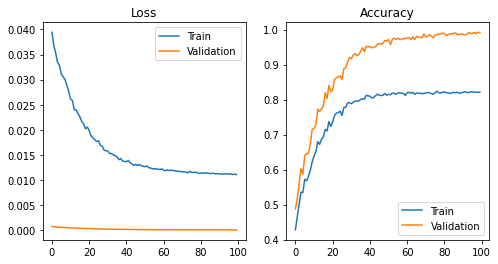

In [10]:
train_and_evaluate(cnn, cnn_optimizer, data_loaders_wgan, num_epochs=EPOCHS)

## LSTM

Training Progress: 	Epoch 1 [0/8883 (0.00%)]		Loss: 1.52343
Training Progress: 	Epoch 1 [320/8883 (3.60%)]		Loss: 1.40141
Training Progress: 	Epoch 1 [640/8883 (7.19%)]		Loss: 1.42502
Training Progress: 	Epoch 1 [960/8883 (10.79%)]		Loss: 1.58219
Training Progress: 	Epoch 1 [1280/8883 (14.39%)]		Loss: 1.35191
Training Progress: 	Epoch 1 [1600/8883 (17.99%)]		Loss: 1.33632
Training Progress: 	Epoch 1 [1920/8883 (21.58%)]		Loss: 1.40616
Training Progress: 	Epoch 1 [2240/8883 (25.18%)]		Loss: 1.49652
Training Progress: 	Epoch 1 [2560/8883 (28.78%)]		Loss: 1.36854
Training Progress: 	Epoch 1 [2880/8883 (32.37%)]		Loss: 1.38680
Training Progress: 	Epoch 1 [3200/8883 (35.97%)]		Loss: 1.41699
Training Progress: 	Epoch 1 [3520/8883 (39.57%)]		Loss: 1.47125
Training Progress: 	Epoch 1 [3840/8883 (43.17%)]		Loss: 1.41455
Training Progress: 	Epoch 1 [4160/8883 (46.76%)]		Loss: 1.40149
Training Progress: 	Epoch 1 [4480/8883 (50.36%)]		Loss: 1.32715
Training Progress: 	Epoch 1 [4800/8883 (53.96%)]	

Training Progress: 	Epoch 5 [2240/8883 (25.18%)]		Loss: 1.30953
Training Progress: 	Epoch 5 [2560/8883 (28.78%)]		Loss: 1.32546
Training Progress: 	Epoch 5 [2880/8883 (32.37%)]		Loss: 1.41747
Training Progress: 	Epoch 5 [3200/8883 (35.97%)]		Loss: 1.34271
Training Progress: 	Epoch 5 [3520/8883 (39.57%)]		Loss: 1.34613
Training Progress: 	Epoch 5 [3840/8883 (43.17%)]		Loss: 1.35431
Training Progress: 	Epoch 5 [4160/8883 (46.76%)]		Loss: 1.28556
Training Progress: 	Epoch 5 [4480/8883 (50.36%)]		Loss: 1.29052
Training Progress: 	Epoch 5 [4800/8883 (53.96%)]		Loss: 1.35214
Training Progress: 	Epoch 5 [5120/8883 (57.55%)]		Loss: 1.37125
Training Progress: 	Epoch 5 [5440/8883 (61.15%)]		Loss: 1.31455
Training Progress: 	Epoch 5 [5760/8883 (64.75%)]		Loss: 1.38390
Training Progress: 	Epoch 5 [6080/8883 (68.35%)]		Loss: 1.32511
Training Progress: 	Epoch 5 [6400/8883 (71.94%)]		Loss: 1.31881
Training Progress: 	Epoch 5 [6720/8883 (75.54%)]		Loss: 1.36203
Training Progress: 	Epoch 5 [7040/8883 (

Training Progress: 	Epoch 9 [4480/8883 (50.36%)]		Loss: 1.16060
Training Progress: 	Epoch 9 [4800/8883 (53.96%)]		Loss: 1.27441
Training Progress: 	Epoch 9 [5120/8883 (57.55%)]		Loss: 1.24406
Training Progress: 	Epoch 9 [5440/8883 (61.15%)]		Loss: 1.33353
Training Progress: 	Epoch 9 [5760/8883 (64.75%)]		Loss: 1.32801
Training Progress: 	Epoch 9 [6080/8883 (68.35%)]		Loss: 1.25986
Training Progress: 	Epoch 9 [6400/8883 (71.94%)]		Loss: 1.27178
Training Progress: 	Epoch 9 [6720/8883 (75.54%)]		Loss: 1.27085
Training Progress: 	Epoch 9 [7040/8883 (79.14%)]		Loss: 1.26755
Training Progress: 	Epoch 9 [7360/8883 (82.73%)]		Loss: 1.20434
Training Progress: 	Epoch 9 [7680/8883 (86.33%)]		Loss: 1.20410
Training Progress: 	Epoch 9 [8000/8883 (89.93%)]		Loss: 1.33015
Training Progress: 	Epoch 9 [8320/8883 (93.53%)]		Loss: 1.29727
Training Progress: 	Epoch 9 [8640/8883 (97.12%)]		Loss: 1.20799
	Train loss: 0.03845, Accuracy: 3832/8883 (43.00%)
	Validation loss: 0.00074, Accuracy: 710/1692 (41.00%

Training Progress: 	Epoch 13 [6400/8883 (71.94%)]		Loss: 1.21749
Training Progress: 	Epoch 13 [6720/8883 (75.54%)]		Loss: 1.15911
Training Progress: 	Epoch 13 [7040/8883 (79.14%)]		Loss: 1.20912
Training Progress: 	Epoch 13 [7360/8883 (82.73%)]		Loss: 1.10154
Training Progress: 	Epoch 13 [7680/8883 (86.33%)]		Loss: 1.04230
Training Progress: 	Epoch 13 [8000/8883 (89.93%)]		Loss: 1.09241
Training Progress: 	Epoch 13 [8320/8883 (93.53%)]		Loss: 1.12717
Training Progress: 	Epoch 13 [8640/8883 (97.12%)]		Loss: 1.20445
	Train loss: 0.03515, Accuracy: 4281/8883 (48.00%)
	Validation loss: 0.00070, Accuracy: 784/1692 (46.00%)
	Test loss: 0.00087, Accuracy: 537/1772 (30.00%)

Training Progress: 	Epoch 14 [0/8883 (0.00%)]		Loss: 1.30621
Training Progress: 	Epoch 14 [320/8883 (3.60%)]		Loss: 1.24538
Training Progress: 	Epoch 14 [640/8883 (7.19%)]		Loss: 1.24225
Training Progress: 	Epoch 14 [960/8883 (10.79%)]		Loss: 1.33059
Training Progress: 	Epoch 14 [1280/8883 (14.39%)]		Loss: 1.12809
Training

Training Progress: 	Epoch 17 [8000/8883 (89.93%)]		Loss: 1.13295
Training Progress: 	Epoch 17 [8320/8883 (93.53%)]		Loss: 1.24254
Training Progress: 	Epoch 17 [8640/8883 (97.12%)]		Loss: 1.11830
	Train loss: 0.03104, Accuracy: 4882/8883 (54.00%)
	Validation loss: 0.00064, Accuracy: 887/1692 (52.00%)
	Test loss: 0.00095, Accuracy: 552/1772 (31.00%)

Training Progress: 	Epoch 18 [0/8883 (0.00%)]		Loss: 1.01844
Training Progress: 	Epoch 18 [320/8883 (3.60%)]		Loss: 1.04549
Training Progress: 	Epoch 18 [640/8883 (7.19%)]		Loss: 1.09613
Training Progress: 	Epoch 18 [960/8883 (10.79%)]		Loss: 0.95411
Training Progress: 	Epoch 18 [1280/8883 (14.39%)]		Loss: 1.24308
Training Progress: 	Epoch 18 [1600/8883 (17.99%)]		Loss: 1.25011
Training Progress: 	Epoch 18 [1920/8883 (21.58%)]		Loss: 1.04148
Training Progress: 	Epoch 18 [2240/8883 (25.18%)]		Loss: 1.14390
Training Progress: 	Epoch 18 [2560/8883 (28.78%)]		Loss: 1.13967
Training Progress: 	Epoch 18 [2880/8883 (32.37%)]		Loss: 1.16490
Training

Training Progress: 	Epoch 22 [0/8883 (0.00%)]		Loss: 0.95159
Training Progress: 	Epoch 22 [320/8883 (3.60%)]		Loss: 1.03424
Training Progress: 	Epoch 22 [640/8883 (7.19%)]		Loss: 1.11961
Training Progress: 	Epoch 22 [960/8883 (10.79%)]		Loss: 1.00437
Training Progress: 	Epoch 22 [1280/8883 (14.39%)]		Loss: 1.04860
Training Progress: 	Epoch 22 [1600/8883 (17.99%)]		Loss: 1.11183
Training Progress: 	Epoch 22 [1920/8883 (21.58%)]		Loss: 1.04519
Training Progress: 	Epoch 22 [2240/8883 (25.18%)]		Loss: 1.02326
Training Progress: 	Epoch 22 [2560/8883 (28.78%)]		Loss: 1.00057
Training Progress: 	Epoch 22 [2880/8883 (32.37%)]		Loss: 1.14804
Training Progress: 	Epoch 22 [3200/8883 (35.97%)]		Loss: 1.06565
Training Progress: 	Epoch 22 [3520/8883 (39.57%)]		Loss: 1.12618
Training Progress: 	Epoch 22 [3840/8883 (43.17%)]		Loss: 1.10261
Training Progress: 	Epoch 22 [4160/8883 (46.76%)]		Loss: 0.84525
Training Progress: 	Epoch 22 [4480/8883 (50.36%)]		Loss: 0.83228
Training Progress: 	Epoch 22 [4800

Training Progress: 	Epoch 26 [1920/8883 (21.58%)]		Loss: 0.94924
Training Progress: 	Epoch 26 [2240/8883 (25.18%)]		Loss: 0.97496
Training Progress: 	Epoch 26 [2560/8883 (28.78%)]		Loss: 1.04541
Training Progress: 	Epoch 26 [2880/8883 (32.37%)]		Loss: 0.98283
Training Progress: 	Epoch 26 [3200/8883 (35.97%)]		Loss: 0.92109
Training Progress: 	Epoch 26 [3520/8883 (39.57%)]		Loss: 0.90255
Training Progress: 	Epoch 26 [3840/8883 (43.17%)]		Loss: 0.97279
Training Progress: 	Epoch 26 [4160/8883 (46.76%)]		Loss: 0.80793
Training Progress: 	Epoch 26 [4480/8883 (50.36%)]		Loss: 0.86932
Training Progress: 	Epoch 26 [4800/8883 (53.96%)]		Loss: 0.64804
Training Progress: 	Epoch 26 [5120/8883 (57.55%)]		Loss: 0.83627
Training Progress: 	Epoch 26 [5440/8883 (61.15%)]		Loss: 0.81666
Training Progress: 	Epoch 26 [5760/8883 (64.75%)]		Loss: 0.79482
Training Progress: 	Epoch 26 [6080/8883 (68.35%)]		Loss: 0.85091
Training Progress: 	Epoch 26 [6400/8883 (71.94%)]		Loss: 1.03798
Training Progress: 	Epoch

Training Progress: 	Epoch 30 [3520/8883 (39.57%)]		Loss: 0.92590
Training Progress: 	Epoch 30 [3840/8883 (43.17%)]		Loss: 0.94144
Training Progress: 	Epoch 30 [4160/8883 (46.76%)]		Loss: 0.85647
Training Progress: 	Epoch 30 [4480/8883 (50.36%)]		Loss: 0.74070
Training Progress: 	Epoch 30 [4800/8883 (53.96%)]		Loss: 0.83689
Training Progress: 	Epoch 30 [5120/8883 (57.55%)]		Loss: 0.98608
Training Progress: 	Epoch 30 [5440/8883 (61.15%)]		Loss: 0.94487
Training Progress: 	Epoch 30 [5760/8883 (64.75%)]		Loss: 0.71853
Training Progress: 	Epoch 30 [6080/8883 (68.35%)]		Loss: 0.70451
Training Progress: 	Epoch 30 [6400/8883 (71.94%)]		Loss: 0.90704
Training Progress: 	Epoch 30 [6720/8883 (75.54%)]		Loss: 0.94657
Training Progress: 	Epoch 30 [7040/8883 (79.14%)]		Loss: 0.92263
Training Progress: 	Epoch 30 [7360/8883 (82.73%)]		Loss: 0.85090
Training Progress: 	Epoch 30 [7680/8883 (86.33%)]		Loss: 0.68377
Training Progress: 	Epoch 30 [8000/8883 (89.93%)]		Loss: 0.73459
Training Progress: 	Epoch

Training Progress: 	Epoch 34 [5120/8883 (57.55%)]		Loss: 0.75100
Training Progress: 	Epoch 34 [5440/8883 (61.15%)]		Loss: 0.72243
Training Progress: 	Epoch 34 [5760/8883 (64.75%)]		Loss: 0.58396
Training Progress: 	Epoch 34 [6080/8883 (68.35%)]		Loss: 0.75127
Training Progress: 	Epoch 34 [6400/8883 (71.94%)]		Loss: 0.78804
Training Progress: 	Epoch 34 [6720/8883 (75.54%)]		Loss: 1.00033
Training Progress: 	Epoch 34 [7040/8883 (79.14%)]		Loss: 0.81268
Training Progress: 	Epoch 34 [7360/8883 (82.73%)]		Loss: 0.85481
Training Progress: 	Epoch 34 [7680/8883 (86.33%)]		Loss: 0.75942
Training Progress: 	Epoch 34 [8000/8883 (89.93%)]		Loss: 0.66129
Training Progress: 	Epoch 34 [8320/8883 (93.53%)]		Loss: 0.92035
Training Progress: 	Epoch 34 [8640/8883 (97.12%)]		Loss: 0.92081
	Train loss: 0.02107, Accuracy: 6153/8883 (69.00%)
	Validation loss: 0.00044, Accuracy: 1191/1692 (70.00%)
	Test loss: 0.00127, Accuracy: 510/1772 (28.00%)

Training Progress: 	Epoch 35 [0/8883 (0.00%)]		Loss: 0.85510
Tr

Training Progress: 	Epoch 38 [6720/8883 (75.54%)]		Loss: 0.81697
Training Progress: 	Epoch 38 [7040/8883 (79.14%)]		Loss: 0.99258
Training Progress: 	Epoch 38 [7360/8883 (82.73%)]		Loss: 0.86498
Training Progress: 	Epoch 38 [7680/8883 (86.33%)]		Loss: 0.70790
Training Progress: 	Epoch 38 [8000/8883 (89.93%)]		Loss: 0.69426
Training Progress: 	Epoch 38 [8320/8883 (93.53%)]		Loss: 1.07307
Training Progress: 	Epoch 38 [8640/8883 (97.12%)]		Loss: 0.91162
	Train loss: 0.01929, Accuracy: 6409/8883 (72.00%)
	Validation loss: 0.00038, Accuracy: 1271/1692 (75.00%)
	Test loss: 0.00127, Accuracy: 529/1772 (29.00%)

Training Progress: 	Epoch 39 [0/8883 (0.00%)]		Loss: 0.78442
Training Progress: 	Epoch 39 [320/8883 (3.60%)]		Loss: 0.64980
Training Progress: 	Epoch 39 [640/8883 (7.19%)]		Loss: 0.73845
Training Progress: 	Epoch 39 [960/8883 (10.79%)]		Loss: 0.57182
Training Progress: 	Epoch 39 [1280/8883 (14.39%)]		Loss: 0.95065
Training Progress: 	Epoch 39 [1600/8883 (17.99%)]		Loss: 1.02742
Trainin

Training Progress: 	Epoch 42 [8320/8883 (93.53%)]		Loss: 0.81019
Training Progress: 	Epoch 42 [8640/8883 (97.12%)]		Loss: 0.71966
	Train loss: 0.01842, Accuracy: 6503/8883 (73.00%)
	Validation loss: 0.00036, Accuracy: 1289/1692 (76.00%)
	Test loss: 0.00136, Accuracy: 531/1772 (29.00%)

Training Progress: 	Epoch 43 [0/8883 (0.00%)]		Loss: 0.59585
Training Progress: 	Epoch 43 [320/8883 (3.60%)]		Loss: 0.79473
Training Progress: 	Epoch 43 [640/8883 (7.19%)]		Loss: 0.52393
Training Progress: 	Epoch 43 [960/8883 (10.79%)]		Loss: 0.83093
Training Progress: 	Epoch 43 [1280/8883 (14.39%)]		Loss: 0.78995
Training Progress: 	Epoch 43 [1600/8883 (17.99%)]		Loss: 0.49403
Training Progress: 	Epoch 43 [1920/8883 (21.58%)]		Loss: 0.63807
Training Progress: 	Epoch 43 [2240/8883 (25.18%)]		Loss: 0.71934
Training Progress: 	Epoch 43 [2560/8883 (28.78%)]		Loss: 1.07503
Training Progress: 	Epoch 43 [2880/8883 (32.37%)]		Loss: 0.72481
Training Progress: 	Epoch 43 [3200/8883 (35.97%)]		Loss: 0.90617
Trainin

Training Progress: 	Epoch 47 [320/8883 (3.60%)]		Loss: 0.75602
Training Progress: 	Epoch 47 [640/8883 (7.19%)]		Loss: 0.64217
Training Progress: 	Epoch 47 [960/8883 (10.79%)]		Loss: 0.71545
Training Progress: 	Epoch 47 [1280/8883 (14.39%)]		Loss: 0.63425
Training Progress: 	Epoch 47 [1600/8883 (17.99%)]		Loss: 0.50295
Training Progress: 	Epoch 47 [1920/8883 (21.58%)]		Loss: 0.51061
Training Progress: 	Epoch 47 [2240/8883 (25.18%)]		Loss: 0.77862
Training Progress: 	Epoch 47 [2560/8883 (28.78%)]		Loss: 0.80617
Training Progress: 	Epoch 47 [2880/8883 (32.37%)]		Loss: 0.55249
Training Progress: 	Epoch 47 [3200/8883 (35.97%)]		Loss: 0.81854
Training Progress: 	Epoch 47 [3520/8883 (39.57%)]		Loss: 0.71119
Training Progress: 	Epoch 47 [3840/8883 (43.17%)]		Loss: 0.62694
Training Progress: 	Epoch 47 [4160/8883 (46.76%)]		Loss: 0.49651
Training Progress: 	Epoch 47 [4480/8883 (50.36%)]		Loss: 0.54077
Training Progress: 	Epoch 47 [4800/8883 (53.96%)]		Loss: 0.39911
Training Progress: 	Epoch 47 [

Training Progress: 	Epoch 51 [2240/8883 (25.18%)]		Loss: 0.66343
Training Progress: 	Epoch 51 [2560/8883 (28.78%)]		Loss: 0.67385
Training Progress: 	Epoch 51 [2880/8883 (32.37%)]		Loss: 0.77433
Training Progress: 	Epoch 51 [3200/8883 (35.97%)]		Loss: 0.74914
Training Progress: 	Epoch 51 [3520/8883 (39.57%)]		Loss: 0.64551
Training Progress: 	Epoch 51 [3840/8883 (43.17%)]		Loss: 0.70375
Training Progress: 	Epoch 51 [4160/8883 (46.76%)]		Loss: 0.66185
Training Progress: 	Epoch 51 [4480/8883 (50.36%)]		Loss: 0.56566
Training Progress: 	Epoch 51 [4800/8883 (53.96%)]		Loss: 0.41941
Training Progress: 	Epoch 51 [5120/8883 (57.55%)]		Loss: 0.67330
Training Progress: 	Epoch 51 [5440/8883 (61.15%)]		Loss: 0.58773
Training Progress: 	Epoch 51 [5760/8883 (64.75%)]		Loss: 0.43492
Training Progress: 	Epoch 51 [6080/8883 (68.35%)]		Loss: 0.49125
Training Progress: 	Epoch 51 [6400/8883 (71.94%)]		Loss: 0.60017
Training Progress: 	Epoch 51 [6720/8883 (75.54%)]		Loss: 0.74888
Training Progress: 	Epoch

Training Progress: 	Epoch 55 [3840/8883 (43.17%)]		Loss: 0.72502
Training Progress: 	Epoch 55 [4160/8883 (46.76%)]		Loss: 0.50042
Training Progress: 	Epoch 55 [4480/8883 (50.36%)]		Loss: 0.57833
Training Progress: 	Epoch 55 [4800/8883 (53.96%)]		Loss: 0.45745
Training Progress: 	Epoch 55 [5120/8883 (57.55%)]		Loss: 0.69192
Training Progress: 	Epoch 55 [5440/8883 (61.15%)]		Loss: 0.57472
Training Progress: 	Epoch 55 [5760/8883 (64.75%)]		Loss: 0.48914
Training Progress: 	Epoch 55 [6080/8883 (68.35%)]		Loss: 0.45776
Training Progress: 	Epoch 55 [6400/8883 (71.94%)]		Loss: 0.75358
Training Progress: 	Epoch 55 [6720/8883 (75.54%)]		Loss: 0.73701
Training Progress: 	Epoch 55 [7040/8883 (79.14%)]		Loss: 0.76071
Training Progress: 	Epoch 55 [7360/8883 (82.73%)]		Loss: 0.62727
Training Progress: 	Epoch 55 [7680/8883 (86.33%)]		Loss: 0.56881
Training Progress: 	Epoch 55 [8000/8883 (89.93%)]		Loss: 0.54937
Training Progress: 	Epoch 55 [8320/8883 (93.53%)]		Loss: 0.86741
Training Progress: 	Epoch

Training Progress: 	Epoch 59 [5440/8883 (61.15%)]		Loss: 0.45205
Training Progress: 	Epoch 59 [5760/8883 (64.75%)]		Loss: 0.43808
Training Progress: 	Epoch 59 [6080/8883 (68.35%)]		Loss: 0.62644
Training Progress: 	Epoch 59 [6400/8883 (71.94%)]		Loss: 0.49116
Training Progress: 	Epoch 59 [6720/8883 (75.54%)]		Loss: 0.76387
Training Progress: 	Epoch 59 [7040/8883 (79.14%)]		Loss: 0.73331
Training Progress: 	Epoch 59 [7360/8883 (82.73%)]		Loss: 0.51892
Training Progress: 	Epoch 59 [7680/8883 (86.33%)]		Loss: 0.54894
Training Progress: 	Epoch 59 [8000/8883 (89.93%)]		Loss: 0.58265
Training Progress: 	Epoch 59 [8320/8883 (93.53%)]		Loss: 0.72718
Training Progress: 	Epoch 59 [8640/8883 (97.12%)]		Loss: 0.72641
	Train loss: 0.01438, Accuracy: 6855/8883 (77.00%)
	Validation loss: 0.00027, Accuracy: 1434/1692 (84.00%)
	Test loss: 0.00154, Accuracy: 568/1772 (32.00%)

Training Progress: 	Epoch 60 [0/8883 (0.00%)]		Loss: 0.51863
Training Progress: 	Epoch 60 [320/8883 (3.60%)]		Loss: 0.50162
Trai

Training Progress: 	Epoch 63 [7040/8883 (79.14%)]		Loss: 0.56140
Training Progress: 	Epoch 63 [7360/8883 (82.73%)]		Loss: 0.53043
Training Progress: 	Epoch 63 [7680/8883 (86.33%)]		Loss: 0.62378
Training Progress: 	Epoch 63 [8000/8883 (89.93%)]		Loss: 0.44503
Training Progress: 	Epoch 63 [8320/8883 (93.53%)]		Loss: 0.49997
Training Progress: 	Epoch 63 [8640/8883 (97.12%)]		Loss: 0.50864
	Train loss: 0.01392, Accuracy: 6935/8883 (78.00%)
	Validation loss: 0.00026, Accuracy: 1441/1692 (85.00%)
	Test loss: 0.00163, Accuracy: 511/1772 (28.00%)

Training Progress: 	Epoch 64 [0/8883 (0.00%)]		Loss: 0.49699
Training Progress: 	Epoch 64 [320/8883 (3.60%)]		Loss: 0.55777
Training Progress: 	Epoch 64 [640/8883 (7.19%)]		Loss: 0.47463
Training Progress: 	Epoch 64 [960/8883 (10.79%)]		Loss: 0.51475
Training Progress: 	Epoch 64 [1280/8883 (14.39%)]		Loss: 0.47063
Training Progress: 	Epoch 64 [1600/8883 (17.99%)]		Loss: 0.65807
Training Progress: 	Epoch 64 [1920/8883 (21.58%)]		Loss: 0.32880
Trainin

Training Progress: 	Epoch 67 [8640/8883 (97.12%)]		Loss: 0.57575
	Train loss: 0.01339, Accuracy: 7014/8883 (78.00%)
	Validation loss: 0.00027, Accuracy: 1425/1692 (84.00%)
	Test loss: 0.00168, Accuracy: 545/1772 (30.00%)

Training Progress: 	Epoch 68 [0/8883 (0.00%)]		Loss: 0.62325
Training Progress: 	Epoch 68 [320/8883 (3.60%)]		Loss: 0.54859
Training Progress: 	Epoch 68 [640/8883 (7.19%)]		Loss: 0.49295
Training Progress: 	Epoch 68 [960/8883 (10.79%)]		Loss: 0.55038
Training Progress: 	Epoch 68 [1280/8883 (14.39%)]		Loss: 0.41493
Training Progress: 	Epoch 68 [1600/8883 (17.99%)]		Loss: 0.60489
Training Progress: 	Epoch 68 [1920/8883 (21.58%)]		Loss: 0.50215
Training Progress: 	Epoch 68 [2240/8883 (25.18%)]		Loss: 0.65383
Training Progress: 	Epoch 68 [2560/8883 (28.78%)]		Loss: 0.58427
Training Progress: 	Epoch 68 [2880/8883 (32.37%)]		Loss: 0.45591
Training Progress: 	Epoch 68 [3200/8883 (35.97%)]		Loss: 0.59625
Training Progress: 	Epoch 68 [3520/8883 (39.57%)]		Loss: 0.77174
Trainin

Training Progress: 	Epoch 72 [640/8883 (7.19%)]		Loss: 0.33386
Training Progress: 	Epoch 72 [960/8883 (10.79%)]		Loss: 0.38895
Training Progress: 	Epoch 72 [1280/8883 (14.39%)]		Loss: 0.53839
Training Progress: 	Epoch 72 [1600/8883 (17.99%)]		Loss: 0.51072
Training Progress: 	Epoch 72 [1920/8883 (21.58%)]		Loss: 0.32969
Training Progress: 	Epoch 72 [2240/8883 (25.18%)]		Loss: 0.53479
Training Progress: 	Epoch 72 [2560/8883 (28.78%)]		Loss: 0.56951
Training Progress: 	Epoch 72 [2880/8883 (32.37%)]		Loss: 0.52156
Training Progress: 	Epoch 72 [3200/8883 (35.97%)]		Loss: 0.51600
Training Progress: 	Epoch 72 [3520/8883 (39.57%)]		Loss: 0.55716
Training Progress: 	Epoch 72 [3840/8883 (43.17%)]		Loss: 0.79500
Training Progress: 	Epoch 72 [4160/8883 (46.76%)]		Loss: 0.29295
Training Progress: 	Epoch 72 [4480/8883 (50.36%)]		Loss: 0.54669
Training Progress: 	Epoch 72 [4800/8883 (53.96%)]		Loss: 0.44044
Training Progress: 	Epoch 72 [5120/8883 (57.55%)]		Loss: 0.56557
Training Progress: 	Epoch 72

Training Progress: 	Epoch 76 [2240/8883 (25.18%)]		Loss: 0.51672
Training Progress: 	Epoch 76 [2560/8883 (28.78%)]		Loss: 0.72397
Training Progress: 	Epoch 76 [2880/8883 (32.37%)]		Loss: 0.79160
Training Progress: 	Epoch 76 [3200/8883 (35.97%)]		Loss: 0.46549
Training Progress: 	Epoch 76 [3520/8883 (39.57%)]		Loss: 0.65342
Training Progress: 	Epoch 76 [3840/8883 (43.17%)]		Loss: 0.59398
Training Progress: 	Epoch 76 [4160/8883 (46.76%)]		Loss: 0.32290
Training Progress: 	Epoch 76 [4480/8883 (50.36%)]		Loss: 0.33339
Training Progress: 	Epoch 76 [4800/8883 (53.96%)]		Loss: 0.30133
Training Progress: 	Epoch 76 [5120/8883 (57.55%)]		Loss: 0.45151
Training Progress: 	Epoch 76 [5440/8883 (61.15%)]		Loss: 0.75416
Training Progress: 	Epoch 76 [5760/8883 (64.75%)]		Loss: 0.43242
Training Progress: 	Epoch 76 [6080/8883 (68.35%)]		Loss: 0.25357
Training Progress: 	Epoch 76 [6400/8883 (71.94%)]		Loss: 0.36751
Training Progress: 	Epoch 76 [6720/8883 (75.54%)]		Loss: 0.65866
Training Progress: 	Epoch

Training Progress: 	Epoch 80 [3840/8883 (43.17%)]		Loss: 0.72765
Training Progress: 	Epoch 80 [4160/8883 (46.76%)]		Loss: 0.47291
Training Progress: 	Epoch 80 [4480/8883 (50.36%)]		Loss: 0.52488
Training Progress: 	Epoch 80 [4800/8883 (53.96%)]		Loss: 0.30381
Training Progress: 	Epoch 80 [5120/8883 (57.55%)]		Loss: 0.65599
Training Progress: 	Epoch 80 [5440/8883 (61.15%)]		Loss: 0.57483
Training Progress: 	Epoch 80 [5760/8883 (64.75%)]		Loss: 0.40000
Training Progress: 	Epoch 80 [6080/8883 (68.35%)]		Loss: 0.55376
Training Progress: 	Epoch 80 [6400/8883 (71.94%)]		Loss: 0.50484
Training Progress: 	Epoch 80 [6720/8883 (75.54%)]		Loss: 1.34109
Training Progress: 	Epoch 80 [7040/8883 (79.14%)]		Loss: 0.62144
Training Progress: 	Epoch 80 [7360/8883 (82.73%)]		Loss: 0.60024
Training Progress: 	Epoch 80 [7680/8883 (86.33%)]		Loss: 0.46148
Training Progress: 	Epoch 80 [8000/8883 (89.93%)]		Loss: 0.43482
Training Progress: 	Epoch 80 [8320/8883 (93.53%)]		Loss: 0.53014
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [5440/8883 (61.15%)]		Loss: 0.70047
Training Progress: 	Epoch 84 [5760/8883 (64.75%)]		Loss: 0.62136
Training Progress: 	Epoch 84 [6080/8883 (68.35%)]		Loss: 0.37533
Training Progress: 	Epoch 84 [6400/8883 (71.94%)]		Loss: 0.67591
Training Progress: 	Epoch 84 [6720/8883 (75.54%)]		Loss: 0.55282
Training Progress: 	Epoch 84 [7040/8883 (79.14%)]		Loss: 0.64340
Training Progress: 	Epoch 84 [7360/8883 (82.73%)]		Loss: 0.55397
Training Progress: 	Epoch 84 [7680/8883 (86.33%)]		Loss: 0.48611
Training Progress: 	Epoch 84 [8000/8883 (89.93%)]		Loss: 0.37512
Training Progress: 	Epoch 84 [8320/8883 (93.53%)]		Loss: 0.41365
Training Progress: 	Epoch 84 [8640/8883 (97.12%)]		Loss: 0.56385
	Train loss: 0.01289, Accuracy: 7070/8883 (79.00%)
	Validation loss: 0.00023, Accuracy: 1482/1692 (87.00%)
	Test loss: 0.00187, Accuracy: 552/1772 (31.00%)

Training Progress: 	Epoch 85 [0/8883 (0.00%)]		Loss: 0.48015
Training Progress: 	Epoch 85 [320/8883 (3.60%)]		Loss: 0.63260
Trai

Training Progress: 	Epoch 88 [7040/8883 (79.14%)]		Loss: 0.55931
Training Progress: 	Epoch 88 [7360/8883 (82.73%)]		Loss: 0.55334
Training Progress: 	Epoch 88 [7680/8883 (86.33%)]		Loss: 0.42321
Training Progress: 	Epoch 88 [8000/8883 (89.93%)]		Loss: 0.58385
Training Progress: 	Epoch 88 [8320/8883 (93.53%)]		Loss: 0.49874
Training Progress: 	Epoch 88 [8640/8883 (97.12%)]		Loss: 0.46532
	Train loss: 0.01184, Accuracy: 7175/8883 (80.00%)
	Validation loss: 0.00018, Accuracy: 1517/1692 (89.00%)
	Test loss: 0.00180, Accuracy: 528/1772 (29.00%)

Training Progress: 	Epoch 89 [0/8883 (0.00%)]		Loss: 0.40179
Training Progress: 	Epoch 89 [320/8883 (3.60%)]		Loss: 0.48405
Training Progress: 	Epoch 89 [640/8883 (7.19%)]		Loss: 0.39828
Training Progress: 	Epoch 89 [960/8883 (10.79%)]		Loss: 0.48164
Training Progress: 	Epoch 89 [1280/8883 (14.39%)]		Loss: 0.69343
Training Progress: 	Epoch 89 [1600/8883 (17.99%)]		Loss: 0.42192
Training Progress: 	Epoch 89 [1920/8883 (21.58%)]		Loss: 0.36917
Trainin

Training Progress: 	Epoch 92 [8640/8883 (97.12%)]		Loss: 0.37672
	Train loss: 0.01229, Accuracy: 7117/8883 (80.00%)
	Validation loss: 0.00020, Accuracy: 1516/1692 (89.00%)
	Test loss: 0.00185, Accuracy: 580/1772 (32.00%)

Training Progress: 	Epoch 93 [0/8883 (0.00%)]		Loss: 0.35502
Training Progress: 	Epoch 93 [320/8883 (3.60%)]		Loss: 0.51351
Training Progress: 	Epoch 93 [640/8883 (7.19%)]		Loss: 0.24764
Training Progress: 	Epoch 93 [960/8883 (10.79%)]		Loss: 0.57722
Training Progress: 	Epoch 93 [1280/8883 (14.39%)]		Loss: 0.44431
Training Progress: 	Epoch 93 [1600/8883 (17.99%)]		Loss: 0.44065
Training Progress: 	Epoch 93 [1920/8883 (21.58%)]		Loss: 0.47803
Training Progress: 	Epoch 93 [2240/8883 (25.18%)]		Loss: 0.52149
Training Progress: 	Epoch 93 [2560/8883 (28.78%)]		Loss: 0.58211
Training Progress: 	Epoch 93 [2880/8883 (32.37%)]		Loss: 0.71318
Training Progress: 	Epoch 93 [3200/8883 (35.97%)]		Loss: 0.51849
Training Progress: 	Epoch 93 [3520/8883 (39.57%)]		Loss: 0.65383
Trainin

Training Progress: 	Epoch 97 [640/8883 (7.19%)]		Loss: 0.40207
Training Progress: 	Epoch 97 [960/8883 (10.79%)]		Loss: 0.49138
Training Progress: 	Epoch 97 [1280/8883 (14.39%)]		Loss: 0.40833
Training Progress: 	Epoch 97 [1600/8883 (17.99%)]		Loss: 0.41907
Training Progress: 	Epoch 97 [1920/8883 (21.58%)]		Loss: 0.48393
Training Progress: 	Epoch 97 [2240/8883 (25.18%)]		Loss: 0.54292
Training Progress: 	Epoch 97 [2560/8883 (28.78%)]		Loss: 0.54373
Training Progress: 	Epoch 97 [2880/8883 (32.37%)]		Loss: 0.47988
Training Progress: 	Epoch 97 [3200/8883 (35.97%)]		Loss: 0.54352
Training Progress: 	Epoch 97 [3520/8883 (39.57%)]		Loss: 0.54534
Training Progress: 	Epoch 97 [3840/8883 (43.17%)]		Loss: 0.57222
Training Progress: 	Epoch 97 [4160/8883 (46.76%)]		Loss: 0.32756
Training Progress: 	Epoch 97 [4480/8883 (50.36%)]		Loss: 0.46456
Training Progress: 	Epoch 97 [4800/8883 (53.96%)]		Loss: 0.29476
Training Progress: 	Epoch 97 [5120/8883 (57.55%)]		Loss: 0.53147
Training Progress: 	Epoch 97

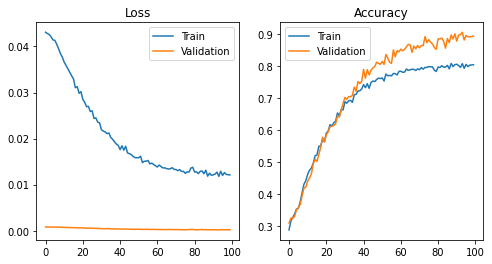

In [11]:
train_and_evaluate(lstm, lstm_optimizer, data_loaders_wgan, num_epochs=EPOCHS)

## GRU

Training Progress: 	Epoch 1 [0/8883 (0.00%)]		Loss: 1.45098
Training Progress: 	Epoch 1 [320/8883 (3.60%)]		Loss: 1.46814
Training Progress: 	Epoch 1 [640/8883 (7.19%)]		Loss: 1.37617
Training Progress: 	Epoch 1 [960/8883 (10.79%)]		Loss: 1.40198
Training Progress: 	Epoch 1 [1280/8883 (14.39%)]		Loss: 1.51732
Training Progress: 	Epoch 1 [1600/8883 (17.99%)]		Loss: 1.38745
Training Progress: 	Epoch 1 [1920/8883 (21.58%)]		Loss: 1.37901
Training Progress: 	Epoch 1 [2240/8883 (25.18%)]		Loss: 1.43939
Training Progress: 	Epoch 1 [2560/8883 (28.78%)]		Loss: 1.43202
Training Progress: 	Epoch 1 [2880/8883 (32.37%)]		Loss: 1.36555
Training Progress: 	Epoch 1 [3200/8883 (35.97%)]		Loss: 1.38377
Training Progress: 	Epoch 1 [3520/8883 (39.57%)]		Loss: 1.39879
Training Progress: 	Epoch 1 [3840/8883 (43.17%)]		Loss: 1.34586
Training Progress: 	Epoch 1 [4160/8883 (46.76%)]		Loss: 1.41579
Training Progress: 	Epoch 1 [4480/8883 (50.36%)]		Loss: 1.37550
Training Progress: 	Epoch 1 [4800/8883 (53.96%)]	

Training Progress: 	Epoch 5 [2240/8883 (25.18%)]		Loss: 1.33125
Training Progress: 	Epoch 5 [2560/8883 (28.78%)]		Loss: 1.32847
Training Progress: 	Epoch 5 [2880/8883 (32.37%)]		Loss: 1.41150
Training Progress: 	Epoch 5 [3200/8883 (35.97%)]		Loss: 1.34822
Training Progress: 	Epoch 5 [3520/8883 (39.57%)]		Loss: 1.35501
Training Progress: 	Epoch 5 [3840/8883 (43.17%)]		Loss: 1.34661
Training Progress: 	Epoch 5 [4160/8883 (46.76%)]		Loss: 1.36485
Training Progress: 	Epoch 5 [4480/8883 (50.36%)]		Loss: 1.28788
Training Progress: 	Epoch 5 [4800/8883 (53.96%)]		Loss: 1.43445
Training Progress: 	Epoch 5 [5120/8883 (57.55%)]		Loss: 1.41163
Training Progress: 	Epoch 5 [5440/8883 (61.15%)]		Loss: 1.32758
Training Progress: 	Epoch 5 [5760/8883 (64.75%)]		Loss: 1.37108
Training Progress: 	Epoch 5 [6080/8883 (68.35%)]		Loss: 1.32197
Training Progress: 	Epoch 5 [6400/8883 (71.94%)]		Loss: 1.36893
Training Progress: 	Epoch 5 [6720/8883 (75.54%)]		Loss: 1.42080
Training Progress: 	Epoch 5 [7040/8883 (

Training Progress: 	Epoch 9 [4480/8883 (50.36%)]		Loss: 1.32353
Training Progress: 	Epoch 9 [4800/8883 (53.96%)]		Loss: 1.38833
Training Progress: 	Epoch 9 [5120/8883 (57.55%)]		Loss: 1.26948
Training Progress: 	Epoch 9 [5440/8883 (61.15%)]		Loss: 1.29389
Training Progress: 	Epoch 9 [5760/8883 (64.75%)]		Loss: 1.36084
Training Progress: 	Epoch 9 [6080/8883 (68.35%)]		Loss: 1.30460
Training Progress: 	Epoch 9 [6400/8883 (71.94%)]		Loss: 1.37292
Training Progress: 	Epoch 9 [6720/8883 (75.54%)]		Loss: 1.34870
Training Progress: 	Epoch 9 [7040/8883 (79.14%)]		Loss: 1.30717
Training Progress: 	Epoch 9 [7360/8883 (82.73%)]		Loss: 1.36178
Training Progress: 	Epoch 9 [7680/8883 (86.33%)]		Loss: 1.36113
Training Progress: 	Epoch 9 [8000/8883 (89.93%)]		Loss: 1.28886
Training Progress: 	Epoch 9 [8320/8883 (93.53%)]		Loss: 1.26579
Training Progress: 	Epoch 9 [8640/8883 (97.12%)]		Loss: 1.28396
	Train loss: 0.03921, Accuracy: 3671/8883 (41.00%)
	Validation loss: 0.00075, Accuracy: 679/1692 (40.00%

Training Progress: 	Epoch 13 [6400/8883 (71.94%)]		Loss: 1.35355
Training Progress: 	Epoch 13 [6720/8883 (75.54%)]		Loss: 1.37455
Training Progress: 	Epoch 13 [7040/8883 (79.14%)]		Loss: 1.19104
Training Progress: 	Epoch 13 [7360/8883 (82.73%)]		Loss: 1.24812
Training Progress: 	Epoch 13 [7680/8883 (86.33%)]		Loss: 1.33558
Training Progress: 	Epoch 13 [8000/8883 (89.93%)]		Loss: 1.02724
Training Progress: 	Epoch 13 [8320/8883 (93.53%)]		Loss: 1.16619
Training Progress: 	Epoch 13 [8640/8883 (97.12%)]		Loss: 1.27667
	Train loss: 0.03642, Accuracy: 4258/8883 (47.00%)
	Validation loss: 0.00070, Accuracy: 792/1692 (46.00%)
	Test loss: 0.00083, Accuracy: 560/1772 (31.00%)

Training Progress: 	Epoch 14 [0/8883 (0.00%)]		Loss: 1.16617
Training Progress: 	Epoch 14 [320/8883 (3.60%)]		Loss: 1.23375
Training Progress: 	Epoch 14 [640/8883 (7.19%)]		Loss: 1.47553
Training Progress: 	Epoch 14 [960/8883 (10.79%)]		Loss: 1.22793
Training Progress: 	Epoch 14 [1280/8883 (14.39%)]		Loss: 1.36966
Training

Training Progress: 	Epoch 17 [8000/8883 (89.93%)]		Loss: 1.05534
Training Progress: 	Epoch 17 [8320/8883 (93.53%)]		Loss: 1.22835
Training Progress: 	Epoch 17 [8640/8883 (97.12%)]		Loss: 1.05594
	Train loss: 0.03389, Accuracy: 4501/8883 (50.00%)
	Validation loss: 0.00069, Accuracy: 823/1692 (48.00%)
	Test loss: 0.00091, Accuracy: 527/1772 (29.00%)

Training Progress: 	Epoch 18 [0/8883 (0.00%)]		Loss: 1.18861
Training Progress: 	Epoch 18 [320/8883 (3.60%)]		Loss: 1.02985
Training Progress: 	Epoch 18 [640/8883 (7.19%)]		Loss: 1.15642
Training Progress: 	Epoch 18 [960/8883 (10.79%)]		Loss: 1.05306
Training Progress: 	Epoch 18 [1280/8883 (14.39%)]		Loss: 1.25359
Training Progress: 	Epoch 18 [1600/8883 (17.99%)]		Loss: 1.23795
Training Progress: 	Epoch 18 [1920/8883 (21.58%)]		Loss: 1.16211
Training Progress: 	Epoch 18 [2240/8883 (25.18%)]		Loss: 1.03055
Training Progress: 	Epoch 18 [2560/8883 (28.78%)]		Loss: 1.11394
Training Progress: 	Epoch 18 [2880/8883 (32.37%)]		Loss: 1.18103
Training

Training Progress: 	Epoch 22 [0/8883 (0.00%)]		Loss: 1.07246
Training Progress: 	Epoch 22 [320/8883 (3.60%)]		Loss: 0.94423
Training Progress: 	Epoch 22 [640/8883 (7.19%)]		Loss: 1.17947
Training Progress: 	Epoch 22 [960/8883 (10.79%)]		Loss: 0.95650
Training Progress: 	Epoch 22 [1280/8883 (14.39%)]		Loss: 1.15973
Training Progress: 	Epoch 22 [1600/8883 (17.99%)]		Loss: 1.22044
Training Progress: 	Epoch 22 [1920/8883 (21.58%)]		Loss: 1.40591
Training Progress: 	Epoch 22 [2240/8883 (25.18%)]		Loss: 0.99698
Training Progress: 	Epoch 22 [2560/8883 (28.78%)]		Loss: 0.99459
Training Progress: 	Epoch 22 [2880/8883 (32.37%)]		Loss: 0.87372
Training Progress: 	Epoch 22 [3200/8883 (35.97%)]		Loss: 1.05121
Training Progress: 	Epoch 22 [3520/8883 (39.57%)]		Loss: 0.99038
Training Progress: 	Epoch 22 [3840/8883 (43.17%)]		Loss: 0.74595
Training Progress: 	Epoch 22 [4160/8883 (46.76%)]		Loss: 1.18710
Training Progress: 	Epoch 22 [4480/8883 (50.36%)]		Loss: 1.12632
Training Progress: 	Epoch 22 [4800

Training Progress: 	Epoch 26 [1920/8883 (21.58%)]		Loss: 1.18431
Training Progress: 	Epoch 26 [2240/8883 (25.18%)]		Loss: 0.78059
Training Progress: 	Epoch 26 [2560/8883 (28.78%)]		Loss: 0.96527
Training Progress: 	Epoch 26 [2880/8883 (32.37%)]		Loss: 0.95593
Training Progress: 	Epoch 26 [3200/8883 (35.97%)]		Loss: 1.02163
Training Progress: 	Epoch 26 [3520/8883 (39.57%)]		Loss: 1.03352
Training Progress: 	Epoch 26 [3840/8883 (43.17%)]		Loss: 0.75170
Training Progress: 	Epoch 26 [4160/8883 (46.76%)]		Loss: 0.91942
Training Progress: 	Epoch 26 [4480/8883 (50.36%)]		Loss: 0.91056
Training Progress: 	Epoch 26 [4800/8883 (53.96%)]		Loss: 0.89350
Training Progress: 	Epoch 26 [5120/8883 (57.55%)]		Loss: 0.97390
Training Progress: 	Epoch 26 [5440/8883 (61.15%)]		Loss: 1.02329
Training Progress: 	Epoch 26 [5760/8883 (64.75%)]		Loss: 1.27965
Training Progress: 	Epoch 26 [6080/8883 (68.35%)]		Loss: 0.89740
Training Progress: 	Epoch 26 [6400/8883 (71.94%)]		Loss: 1.21681
Training Progress: 	Epoch

Training Progress: 	Epoch 30 [3520/8883 (39.57%)]		Loss: 1.17855
Training Progress: 	Epoch 30 [3840/8883 (43.17%)]		Loss: 0.85543
Training Progress: 	Epoch 30 [4160/8883 (46.76%)]		Loss: 0.81795
Training Progress: 	Epoch 30 [4480/8883 (50.36%)]		Loss: 0.72781
Training Progress: 	Epoch 30 [4800/8883 (53.96%)]		Loss: 0.66992
Training Progress: 	Epoch 30 [5120/8883 (57.55%)]		Loss: 0.89187
Training Progress: 	Epoch 30 [5440/8883 (61.15%)]		Loss: 1.01587
Training Progress: 	Epoch 30 [5760/8883 (64.75%)]		Loss: 1.02973
Training Progress: 	Epoch 30 [6080/8883 (68.35%)]		Loss: 0.78837
Training Progress: 	Epoch 30 [6400/8883 (71.94%)]		Loss: 1.15024
Training Progress: 	Epoch 30 [6720/8883 (75.54%)]		Loss: 0.97120
Training Progress: 	Epoch 30 [7040/8883 (79.14%)]		Loss: 0.75010
Training Progress: 	Epoch 30 [7360/8883 (82.73%)]		Loss: 1.04182
Training Progress: 	Epoch 30 [7680/8883 (86.33%)]		Loss: 0.78424
Training Progress: 	Epoch 30 [8000/8883 (89.93%)]		Loss: 1.04833
Training Progress: 	Epoch

Training Progress: 	Epoch 34 [5120/8883 (57.55%)]		Loss: 0.97580
Training Progress: 	Epoch 34 [5440/8883 (61.15%)]		Loss: 0.79681
Training Progress: 	Epoch 34 [5760/8883 (64.75%)]		Loss: 1.16832
Training Progress: 	Epoch 34 [6080/8883 (68.35%)]		Loss: 0.68137
Training Progress: 	Epoch 34 [6400/8883 (71.94%)]		Loss: 0.88576
Training Progress: 	Epoch 34 [6720/8883 (75.54%)]		Loss: 0.76190
Training Progress: 	Epoch 34 [7040/8883 (79.14%)]		Loss: 0.57851
Training Progress: 	Epoch 34 [7360/8883 (82.73%)]		Loss: 0.78610
Training Progress: 	Epoch 34 [7680/8883 (86.33%)]		Loss: 0.68296
Training Progress: 	Epoch 34 [8000/8883 (89.93%)]		Loss: 1.00283
Training Progress: 	Epoch 34 [8320/8883 (93.53%)]		Loss: 0.87385
Training Progress: 	Epoch 34 [8640/8883 (97.12%)]		Loss: 0.59808
	Train loss: 0.02189, Accuracy: 6073/8883 (68.00%)
	Validation loss: 0.00046, Accuracy: 1197/1692 (70.00%)
	Test loss: 0.00111, Accuracy: 656/1772 (37.00%)

Training Progress: 	Epoch 35 [0/8883 (0.00%)]		Loss: 0.76034
Tr

Training Progress: 	Epoch 38 [6720/8883 (75.54%)]		Loss: 0.89525
Training Progress: 	Epoch 38 [7040/8883 (79.14%)]		Loss: 0.71406
Training Progress: 	Epoch 38 [7360/8883 (82.73%)]		Loss: 0.66710
Training Progress: 	Epoch 38 [7680/8883 (86.33%)]		Loss: 0.87703
Training Progress: 	Epoch 38 [8000/8883 (89.93%)]		Loss: 0.58972
Training Progress: 	Epoch 38 [8320/8883 (93.53%)]		Loss: 0.92635
Training Progress: 	Epoch 38 [8640/8883 (97.12%)]		Loss: 0.61023
	Train loss: 0.01987, Accuracy: 6336/8883 (71.00%)
	Validation loss: 0.00044, Accuracy: 1252/1692 (73.00%)
	Test loss: 0.00128, Accuracy: 673/1772 (37.00%)

Training Progress: 	Epoch 39 [0/8883 (0.00%)]		Loss: 0.56993
Training Progress: 	Epoch 39 [320/8883 (3.60%)]		Loss: 0.63092
Training Progress: 	Epoch 39 [640/8883 (7.19%)]		Loss: 0.74271
Training Progress: 	Epoch 39 [960/8883 (10.79%)]		Loss: 0.68400
Training Progress: 	Epoch 39 [1280/8883 (14.39%)]		Loss: 0.66316
Training Progress: 	Epoch 39 [1600/8883 (17.99%)]		Loss: 0.99304
Trainin

Training Progress: 	Epoch 42 [8320/8883 (93.53%)]		Loss: 0.77782
Training Progress: 	Epoch 42 [8640/8883 (97.12%)]		Loss: 0.56303
	Train loss: 0.01866, Accuracy: 6434/8883 (72.00%)
	Validation loss: 0.00038, Accuracy: 1304/1692 (77.00%)
	Test loss: 0.00125, Accuracy: 689/1772 (38.00%)

Training Progress: 	Epoch 43 [0/8883 (0.00%)]		Loss: 0.49126
Training Progress: 	Epoch 43 [320/8883 (3.60%)]		Loss: 0.61464
Training Progress: 	Epoch 43 [640/8883 (7.19%)]		Loss: 0.64233
Training Progress: 	Epoch 43 [960/8883 (10.79%)]		Loss: 0.61957
Training Progress: 	Epoch 43 [1280/8883 (14.39%)]		Loss: 0.62020
Training Progress: 	Epoch 43 [1600/8883 (17.99%)]		Loss: 0.89929
Training Progress: 	Epoch 43 [1920/8883 (21.58%)]		Loss: 0.79611
Training Progress: 	Epoch 43 [2240/8883 (25.18%)]		Loss: 0.74503
Training Progress: 	Epoch 43 [2560/8883 (28.78%)]		Loss: 0.68054
Training Progress: 	Epoch 43 [2880/8883 (32.37%)]		Loss: 0.52065
Training Progress: 	Epoch 43 [3200/8883 (35.97%)]		Loss: 0.78507
Trainin

Training Progress: 	Epoch 47 [320/8883 (3.60%)]		Loss: 0.65595
Training Progress: 	Epoch 47 [640/8883 (7.19%)]		Loss: 0.88994
Training Progress: 	Epoch 47 [960/8883 (10.79%)]		Loss: 0.73071
Training Progress: 	Epoch 47 [1280/8883 (14.39%)]		Loss: 0.75886
Training Progress: 	Epoch 47 [1600/8883 (17.99%)]		Loss: 0.92873
Training Progress: 	Epoch 47 [1920/8883 (21.58%)]		Loss: 0.62482
Training Progress: 	Epoch 47 [2240/8883 (25.18%)]		Loss: 0.88188
Training Progress: 	Epoch 47 [2560/8883 (28.78%)]		Loss: 0.64249
Training Progress: 	Epoch 47 [2880/8883 (32.37%)]		Loss: 0.56301
Training Progress: 	Epoch 47 [3200/8883 (35.97%)]		Loss: 0.84228
Training Progress: 	Epoch 47 [3520/8883 (39.57%)]		Loss: 0.77099
Training Progress: 	Epoch 47 [3840/8883 (43.17%)]		Loss: 0.40756
Training Progress: 	Epoch 47 [4160/8883 (46.76%)]		Loss: 0.66654
Training Progress: 	Epoch 47 [4480/8883 (50.36%)]		Loss: 0.66631
Training Progress: 	Epoch 47 [4800/8883 (53.96%)]		Loss: 0.52832
Training Progress: 	Epoch 47 [

Training Progress: 	Epoch 51 [2240/8883 (25.18%)]		Loss: 0.63631
Training Progress: 	Epoch 51 [2560/8883 (28.78%)]		Loss: 0.45060
Training Progress: 	Epoch 51 [2880/8883 (32.37%)]		Loss: 0.54081
Training Progress: 	Epoch 51 [3200/8883 (35.97%)]		Loss: 0.82405
Training Progress: 	Epoch 51 [3520/8883 (39.57%)]		Loss: 0.80840
Training Progress: 	Epoch 51 [3840/8883 (43.17%)]		Loss: 0.46911
Training Progress: 	Epoch 51 [4160/8883 (46.76%)]		Loss: 0.79797
Training Progress: 	Epoch 51 [4480/8883 (50.36%)]		Loss: 0.43851
Training Progress: 	Epoch 51 [4800/8883 (53.96%)]		Loss: 0.50866
Training Progress: 	Epoch 51 [5120/8883 (57.55%)]		Loss: 0.59169
Training Progress: 	Epoch 51 [5440/8883 (61.15%)]		Loss: 0.62700
Training Progress: 	Epoch 51 [5760/8883 (64.75%)]		Loss: 0.69559
Training Progress: 	Epoch 51 [6080/8883 (68.35%)]		Loss: 0.57989
Training Progress: 	Epoch 51 [6400/8883 (71.94%)]		Loss: 0.69049
Training Progress: 	Epoch 51 [6720/8883 (75.54%)]		Loss: 0.64002
Training Progress: 	Epoch

Training Progress: 	Epoch 55 [3840/8883 (43.17%)]		Loss: 0.34048
Training Progress: 	Epoch 55 [4160/8883 (46.76%)]		Loss: 0.52565
Training Progress: 	Epoch 55 [4480/8883 (50.36%)]		Loss: 0.58428
Training Progress: 	Epoch 55 [4800/8883 (53.96%)]		Loss: 0.40932
Training Progress: 	Epoch 55 [5120/8883 (57.55%)]		Loss: 0.62875
Training Progress: 	Epoch 55 [5440/8883 (61.15%)]		Loss: 0.74290
Training Progress: 	Epoch 55 [5760/8883 (64.75%)]		Loss: 0.89364
Training Progress: 	Epoch 55 [6080/8883 (68.35%)]		Loss: 0.59954
Training Progress: 	Epoch 55 [6400/8883 (71.94%)]		Loss: 0.69764
Training Progress: 	Epoch 55 [6720/8883 (75.54%)]		Loss: 0.62084
Training Progress: 	Epoch 55 [7040/8883 (79.14%)]		Loss: 0.44726
Training Progress: 	Epoch 55 [7360/8883 (82.73%)]		Loss: 0.64108
Training Progress: 	Epoch 55 [7680/8883 (86.33%)]		Loss: 0.81943
Training Progress: 	Epoch 55 [8000/8883 (89.93%)]		Loss: 0.58667
Training Progress: 	Epoch 55 [8320/8883 (93.53%)]		Loss: 0.79776
Training Progress: 	Epoch

Training Progress: 	Epoch 59 [5440/8883 (61.15%)]		Loss: 0.57695
Training Progress: 	Epoch 59 [5760/8883 (64.75%)]		Loss: 0.93018
Training Progress: 	Epoch 59 [6080/8883 (68.35%)]		Loss: 0.55044
Training Progress: 	Epoch 59 [6400/8883 (71.94%)]		Loss: 0.67014
Training Progress: 	Epoch 59 [6720/8883 (75.54%)]		Loss: 0.69825
Training Progress: 	Epoch 59 [7040/8883 (79.14%)]		Loss: 0.38652
Training Progress: 	Epoch 59 [7360/8883 (82.73%)]		Loss: 0.73810
Training Progress: 	Epoch 59 [7680/8883 (86.33%)]		Loss: 0.64075
Training Progress: 	Epoch 59 [8000/8883 (89.93%)]		Loss: 0.60255
Training Progress: 	Epoch 59 [8320/8883 (93.53%)]		Loss: 0.65561
Training Progress: 	Epoch 59 [8640/8883 (97.12%)]		Loss: 0.40269
	Train loss: 0.01559, Accuracy: 6769/8883 (76.00%)
	Validation loss: 0.00032, Accuracy: 1385/1692 (81.00%)
	Test loss: 0.00146, Accuracy: 733/1772 (41.00%)

Training Progress: 	Epoch 60 [0/8883 (0.00%)]		Loss: 0.38539
Training Progress: 	Epoch 60 [320/8883 (3.60%)]		Loss: 0.55133
Trai

Training Progress: 	Epoch 63 [7040/8883 (79.14%)]		Loss: 0.55449
Training Progress: 	Epoch 63 [7360/8883 (82.73%)]		Loss: 0.65206
Training Progress: 	Epoch 63 [7680/8883 (86.33%)]		Loss: 0.45063
Training Progress: 	Epoch 63 [8000/8883 (89.93%)]		Loss: 0.61532
Training Progress: 	Epoch 63 [8320/8883 (93.53%)]		Loss: 0.64342
Training Progress: 	Epoch 63 [8640/8883 (97.12%)]		Loss: 0.47800
	Train loss: 0.01357, Accuracy: 6994/8883 (78.00%)
	Validation loss: 0.00024, Accuracy: 1459/1692 (86.00%)
	Test loss: 0.00147, Accuracy: 717/1772 (40.00%)

Training Progress: 	Epoch 64 [0/8883 (0.00%)]		Loss: 0.66724
Training Progress: 	Epoch 64 [320/8883 (3.60%)]		Loss: 0.55241
Training Progress: 	Epoch 64 [640/8883 (7.19%)]		Loss: 0.63290
Training Progress: 	Epoch 64 [960/8883 (10.79%)]		Loss: 0.50025
Training Progress: 	Epoch 64 [1280/8883 (14.39%)]		Loss: 0.58421
Training Progress: 	Epoch 64 [1600/8883 (17.99%)]		Loss: 1.03905
Training Progress: 	Epoch 64 [1920/8883 (21.58%)]		Loss: 0.44571
Trainin

Training Progress: 	Epoch 67 [8640/8883 (97.12%)]		Loss: 0.38378
	Train loss: 0.01413, Accuracy: 6919/8883 (77.00%)
	Validation loss: 0.00027, Accuracy: 1433/1692 (84.00%)
	Test loss: 0.00161, Accuracy: 733/1772 (41.00%)

Training Progress: 	Epoch 68 [0/8883 (0.00%)]		Loss: 0.34700
Training Progress: 	Epoch 68 [320/8883 (3.60%)]		Loss: 0.52511
Training Progress: 	Epoch 68 [640/8883 (7.19%)]		Loss: 0.46220
Training Progress: 	Epoch 68 [960/8883 (10.79%)]		Loss: 0.42714
Training Progress: 	Epoch 68 [1280/8883 (14.39%)]		Loss: 0.50061
Training Progress: 	Epoch 68 [1600/8883 (17.99%)]		Loss: 0.76222
Training Progress: 	Epoch 68 [1920/8883 (21.58%)]		Loss: 0.57772
Training Progress: 	Epoch 68 [2240/8883 (25.18%)]		Loss: 0.39401
Training Progress: 	Epoch 68 [2560/8883 (28.78%)]		Loss: 0.53818
Training Progress: 	Epoch 68 [2880/8883 (32.37%)]		Loss: 0.55842
Training Progress: 	Epoch 68 [3200/8883 (35.97%)]		Loss: 0.74880
Training Progress: 	Epoch 68 [3520/8883 (39.57%)]		Loss: 0.58700
Trainin

Training Progress: 	Epoch 72 [640/8883 (7.19%)]		Loss: 0.47167
Training Progress: 	Epoch 72 [960/8883 (10.79%)]		Loss: 0.37003
Training Progress: 	Epoch 72 [1280/8883 (14.39%)]		Loss: 0.65022
Training Progress: 	Epoch 72 [1600/8883 (17.99%)]		Loss: 0.71442
Training Progress: 	Epoch 72 [1920/8883 (21.58%)]		Loss: 0.75857
Training Progress: 	Epoch 72 [2240/8883 (25.18%)]		Loss: 0.49299
Training Progress: 	Epoch 72 [2560/8883 (28.78%)]		Loss: 0.52340
Training Progress: 	Epoch 72 [2880/8883 (32.37%)]		Loss: 0.52057
Training Progress: 	Epoch 72 [3200/8883 (35.97%)]		Loss: 0.76657
Training Progress: 	Epoch 72 [3520/8883 (39.57%)]		Loss: 0.40006
Training Progress: 	Epoch 72 [3840/8883 (43.17%)]		Loss: 0.20366
Training Progress: 	Epoch 72 [4160/8883 (46.76%)]		Loss: 0.85189
Training Progress: 	Epoch 72 [4480/8883 (50.36%)]		Loss: 0.41258
Training Progress: 	Epoch 72 [4800/8883 (53.96%)]		Loss: 0.44640
Training Progress: 	Epoch 72 [5120/8883 (57.55%)]		Loss: 0.56344
Training Progress: 	Epoch 72

Training Progress: 	Epoch 76 [2240/8883 (25.18%)]		Loss: 0.38338
Training Progress: 	Epoch 76 [2560/8883 (28.78%)]		Loss: 0.38410
Training Progress: 	Epoch 76 [2880/8883 (32.37%)]		Loss: 0.57435
Training Progress: 	Epoch 76 [3200/8883 (35.97%)]		Loss: 0.68917
Training Progress: 	Epoch 76 [3520/8883 (39.57%)]		Loss: 0.76972
Training Progress: 	Epoch 76 [3840/8883 (43.17%)]		Loss: 0.38279
Training Progress: 	Epoch 76 [4160/8883 (46.76%)]		Loss: 0.51684
Training Progress: 	Epoch 76 [4480/8883 (50.36%)]		Loss: 0.46049
Training Progress: 	Epoch 76 [4800/8883 (53.96%)]		Loss: 0.24687
Training Progress: 	Epoch 76 [5120/8883 (57.55%)]		Loss: 0.56028
Training Progress: 	Epoch 76 [5440/8883 (61.15%)]		Loss: 0.63025
Training Progress: 	Epoch 76 [5760/8883 (64.75%)]		Loss: 0.75734
Training Progress: 	Epoch 76 [6080/8883 (68.35%)]		Loss: 0.49424
Training Progress: 	Epoch 76 [6400/8883 (71.94%)]		Loss: 0.56797
Training Progress: 	Epoch 76 [6720/8883 (75.54%)]		Loss: 0.56162
Training Progress: 	Epoch

Training Progress: 	Epoch 80 [3840/8883 (43.17%)]		Loss: 0.19871
Training Progress: 	Epoch 80 [4160/8883 (46.76%)]		Loss: 0.51218
Training Progress: 	Epoch 80 [4480/8883 (50.36%)]		Loss: 0.45278
Training Progress: 	Epoch 80 [4800/8883 (53.96%)]		Loss: 0.36490
Training Progress: 	Epoch 80 [5120/8883 (57.55%)]		Loss: 0.49329
Training Progress: 	Epoch 80 [5440/8883 (61.15%)]		Loss: 0.48497
Training Progress: 	Epoch 80 [5760/8883 (64.75%)]		Loss: 0.79005
Training Progress: 	Epoch 80 [6080/8883 (68.35%)]		Loss: 0.48418
Training Progress: 	Epoch 80 [6400/8883 (71.94%)]		Loss: 0.50990
Training Progress: 	Epoch 80 [6720/8883 (75.54%)]		Loss: 0.61563
Training Progress: 	Epoch 80 [7040/8883 (79.14%)]		Loss: 0.36811
Training Progress: 	Epoch 80 [7360/8883 (82.73%)]		Loss: 0.44076
Training Progress: 	Epoch 80 [7680/8883 (86.33%)]		Loss: 0.42809
Training Progress: 	Epoch 80 [8000/8883 (89.93%)]		Loss: 0.46843
Training Progress: 	Epoch 80 [8320/8883 (93.53%)]		Loss: 0.39036
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [5440/8883 (61.15%)]		Loss: 0.51603
Training Progress: 	Epoch 84 [5760/8883 (64.75%)]		Loss: 0.53512
Training Progress: 	Epoch 84 [6080/8883 (68.35%)]		Loss: 0.47331
Training Progress: 	Epoch 84 [6400/8883 (71.94%)]		Loss: 0.67520
Training Progress: 	Epoch 84 [6720/8883 (75.54%)]		Loss: 0.61746
Training Progress: 	Epoch 84 [7040/8883 (79.14%)]		Loss: 0.47324
Training Progress: 	Epoch 84 [7360/8883 (82.73%)]		Loss: 0.51660
Training Progress: 	Epoch 84 [7680/8883 (86.33%)]		Loss: 0.42791
Training Progress: 	Epoch 84 [8000/8883 (89.93%)]		Loss: 0.38469
Training Progress: 	Epoch 84 [8320/8883 (93.53%)]		Loss: 0.59976
Training Progress: 	Epoch 84 [8640/8883 (97.12%)]		Loss: 0.32420
	Train loss: 0.01273, Accuracy: 7070/8883 (79.00%)
	Validation loss: 0.00024, Accuracy: 1483/1692 (87.00%)
	Test loss: 0.00161, Accuracy: 733/1772 (41.00%)

Training Progress: 	Epoch 85 [0/8883 (0.00%)]		Loss: 0.33272
Training Progress: 	Epoch 85 [320/8883 (3.60%)]		Loss: 0.72938
Trai

Training Progress: 	Epoch 88 [7040/8883 (79.14%)]		Loss: 0.45755
Training Progress: 	Epoch 88 [7360/8883 (82.73%)]		Loss: 0.55686
Training Progress: 	Epoch 88 [7680/8883 (86.33%)]		Loss: 0.45537
Training Progress: 	Epoch 88 [8000/8883 (89.93%)]		Loss: 0.51581
Training Progress: 	Epoch 88 [8320/8883 (93.53%)]		Loss: 0.55201
Training Progress: 	Epoch 88 [8640/8883 (97.12%)]		Loss: 0.32544
	Train loss: 0.01222, Accuracy: 7104/8883 (79.00%)
	Validation loss: 0.00021, Accuracy: 1505/1692 (88.00%)
	Test loss: 0.00175, Accuracy: 719/1772 (40.00%)

Training Progress: 	Epoch 89 [0/8883 (0.00%)]		Loss: 0.42429
Training Progress: 	Epoch 89 [320/8883 (3.60%)]		Loss: 0.55765
Training Progress: 	Epoch 89 [640/8883 (7.19%)]		Loss: 0.33769
Training Progress: 	Epoch 89 [960/8883 (10.79%)]		Loss: 0.40357
Training Progress: 	Epoch 89 [1280/8883 (14.39%)]		Loss: 0.52245
Training Progress: 	Epoch 89 [1600/8883 (17.99%)]		Loss: 0.67935
Training Progress: 	Epoch 89 [1920/8883 (21.58%)]		Loss: 0.34956
Trainin

Training Progress: 	Epoch 92 [8640/8883 (97.12%)]		Loss: 0.51457
	Train loss: 0.01206, Accuracy: 7123/8883 (80.00%)
	Validation loss: 0.00020, Accuracy: 1528/1692 (90.00%)
	Test loss: 0.00178, Accuracy: 744/1772 (41.00%)

Training Progress: 	Epoch 93 [0/8883 (0.00%)]		Loss: 0.34572
Training Progress: 	Epoch 93 [320/8883 (3.60%)]		Loss: 0.50185
Training Progress: 	Epoch 93 [640/8883 (7.19%)]		Loss: 0.31781
Training Progress: 	Epoch 93 [960/8883 (10.79%)]		Loss: 0.29088
Training Progress: 	Epoch 93 [1280/8883 (14.39%)]		Loss: 0.51448
Training Progress: 	Epoch 93 [1600/8883 (17.99%)]		Loss: 0.78904
Training Progress: 	Epoch 93 [1920/8883 (21.58%)]		Loss: 0.35398
Training Progress: 	Epoch 93 [2240/8883 (25.18%)]		Loss: 0.43037
Training Progress: 	Epoch 93 [2560/8883 (28.78%)]		Loss: 0.43439
Training Progress: 	Epoch 93 [2880/8883 (32.37%)]		Loss: 0.35214
Training Progress: 	Epoch 93 [3200/8883 (35.97%)]		Loss: 0.68376
Training Progress: 	Epoch 93 [3520/8883 (39.57%)]		Loss: 0.43826
Trainin

Training Progress: 	Epoch 97 [640/8883 (7.19%)]		Loss: 0.30531
Training Progress: 	Epoch 97 [960/8883 (10.79%)]		Loss: 0.46824
Training Progress: 	Epoch 97 [1280/8883 (14.39%)]		Loss: 0.57689
Training Progress: 	Epoch 97 [1600/8883 (17.99%)]		Loss: 0.71254
Training Progress: 	Epoch 97 [1920/8883 (21.58%)]		Loss: 0.44056
Training Progress: 	Epoch 97 [2240/8883 (25.18%)]		Loss: 0.50563
Training Progress: 	Epoch 97 [2560/8883 (28.78%)]		Loss: 0.43628
Training Progress: 	Epoch 97 [2880/8883 (32.37%)]		Loss: 0.42786
Training Progress: 	Epoch 97 [3200/8883 (35.97%)]		Loss: 0.64007
Training Progress: 	Epoch 97 [3520/8883 (39.57%)]		Loss: 0.77046
Training Progress: 	Epoch 97 [3840/8883 (43.17%)]		Loss: 0.27247
Training Progress: 	Epoch 97 [4160/8883 (46.76%)]		Loss: 0.45267
Training Progress: 	Epoch 97 [4480/8883 (50.36%)]		Loss: 0.42441
Training Progress: 	Epoch 97 [4800/8883 (53.96%)]		Loss: 0.39397
Training Progress: 	Epoch 97 [5120/8883 (57.55%)]		Loss: 0.49537
Training Progress: 	Epoch 97

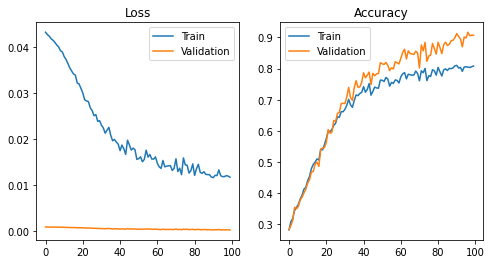

In [13]:
train_and_evaluate(gru, gru_optimizer, data_loaders_wgan, num_epochs=EPOCHS)

## CNN+LSTM

Training Progress: 	Epoch 1 [0/8883 (0.00%)]		Loss: 1.42451
Training Progress: 	Epoch 1 [320/8883 (3.60%)]		Loss: 1.47733
Training Progress: 	Epoch 1 [640/8883 (7.19%)]		Loss: 1.46839
Training Progress: 	Epoch 1 [960/8883 (10.79%)]		Loss: 1.39826
Training Progress: 	Epoch 1 [1280/8883 (14.39%)]		Loss: 1.38385
Training Progress: 	Epoch 1 [1600/8883 (17.99%)]		Loss: 1.40421
Training Progress: 	Epoch 1 [1920/8883 (21.58%)]		Loss: 1.40607
Training Progress: 	Epoch 1 [2240/8883 (25.18%)]		Loss: 1.49024
Training Progress: 	Epoch 1 [2560/8883 (28.78%)]		Loss: 1.42814
Training Progress: 	Epoch 1 [2880/8883 (32.37%)]		Loss: 1.39151
Training Progress: 	Epoch 1 [3200/8883 (35.97%)]		Loss: 1.43350
Training Progress: 	Epoch 1 [3520/8883 (39.57%)]		Loss: 1.45928
Training Progress: 	Epoch 1 [3840/8883 (43.17%)]		Loss: 1.38178
Training Progress: 	Epoch 1 [4160/8883 (46.76%)]		Loss: 1.45819
Training Progress: 	Epoch 1 [4480/8883 (50.36%)]		Loss: 1.38655
Training Progress: 	Epoch 1 [4800/8883 (53.96%)]	

Training Progress: 	Epoch 5 [2240/8883 (25.18%)]		Loss: 1.25087
Training Progress: 	Epoch 5 [2560/8883 (28.78%)]		Loss: 1.33487
Training Progress: 	Epoch 5 [2880/8883 (32.37%)]		Loss: 1.28512
Training Progress: 	Epoch 5 [3200/8883 (35.97%)]		Loss: 1.25225
Training Progress: 	Epoch 5 [3520/8883 (39.57%)]		Loss: 1.37163
Training Progress: 	Epoch 5 [3840/8883 (43.17%)]		Loss: 1.42906
Training Progress: 	Epoch 5 [4160/8883 (46.76%)]		Loss: 1.30774
Training Progress: 	Epoch 5 [4480/8883 (50.36%)]		Loss: 1.25303
Training Progress: 	Epoch 5 [4800/8883 (53.96%)]		Loss: 1.21760
Training Progress: 	Epoch 5 [5120/8883 (57.55%)]		Loss: 1.18041
Training Progress: 	Epoch 5 [5440/8883 (61.15%)]		Loss: 1.30690
Training Progress: 	Epoch 5 [5760/8883 (64.75%)]		Loss: 1.29318
Training Progress: 	Epoch 5 [6080/8883 (68.35%)]		Loss: 1.27261
Training Progress: 	Epoch 5 [6400/8883 (71.94%)]		Loss: 1.18441
Training Progress: 	Epoch 5 [6720/8883 (75.54%)]		Loss: 1.10193
Training Progress: 	Epoch 5 [7040/8883 (

Training Progress: 	Epoch 9 [4480/8883 (50.36%)]		Loss: 1.11843
Training Progress: 	Epoch 9 [4800/8883 (53.96%)]		Loss: 1.15523
Training Progress: 	Epoch 9 [5120/8883 (57.55%)]		Loss: 1.17110
Training Progress: 	Epoch 9 [5440/8883 (61.15%)]		Loss: 1.41723
Training Progress: 	Epoch 9 [5760/8883 (64.75%)]		Loss: 1.20661
Training Progress: 	Epoch 9 [6080/8883 (68.35%)]		Loss: 1.04153
Training Progress: 	Epoch 9 [6400/8883 (71.94%)]		Loss: 1.09999
Training Progress: 	Epoch 9 [6720/8883 (75.54%)]		Loss: 1.06944
Training Progress: 	Epoch 9 [7040/8883 (79.14%)]		Loss: 1.28196
Training Progress: 	Epoch 9 [7360/8883 (82.73%)]		Loss: 1.20755
Training Progress: 	Epoch 9 [7680/8883 (86.33%)]		Loss: 1.07629
Training Progress: 	Epoch 9 [8000/8883 (89.93%)]		Loss: 1.17035
Training Progress: 	Epoch 9 [8320/8883 (93.53%)]		Loss: 1.17704
Training Progress: 	Epoch 9 [8640/8883 (97.12%)]		Loss: 1.30985
	Train loss: 0.03497, Accuracy: 4282/8883 (48.00%)
	Validation loss: 0.00063, Accuracy: 887/1692 (52.00%

Training Progress: 	Epoch 13 [6400/8883 (71.94%)]		Loss: 0.99764
Training Progress: 	Epoch 13 [6720/8883 (75.54%)]		Loss: 1.06968
Training Progress: 	Epoch 13 [7040/8883 (79.14%)]		Loss: 1.23026
Training Progress: 	Epoch 13 [7360/8883 (82.73%)]		Loss: 1.33456
Training Progress: 	Epoch 13 [7680/8883 (86.33%)]		Loss: 1.19481
Training Progress: 	Epoch 13 [8000/8883 (89.93%)]		Loss: 1.20265
Training Progress: 	Epoch 13 [8320/8883 (93.53%)]		Loss: 1.13584
Training Progress: 	Epoch 13 [8640/8883 (97.12%)]		Loss: 1.19276
	Train loss: 0.03216, Accuracy: 4713/8883 (53.00%)
	Validation loss: 0.00058, Accuracy: 959/1692 (56.00%)
	Test loss: 0.00063, Accuracy: 853/1772 (48.00%)

Training Progress: 	Epoch 14 [0/8883 (0.00%)]		Loss: 1.09027
Training Progress: 	Epoch 14 [320/8883 (3.60%)]		Loss: 1.33755
Training Progress: 	Epoch 14 [640/8883 (7.19%)]		Loss: 1.08016
Training Progress: 	Epoch 14 [960/8883 (10.79%)]		Loss: 1.18147
Training Progress: 	Epoch 14 [1280/8883 (14.39%)]		Loss: 1.28671
Training

Training Progress: 	Epoch 17 [8000/8883 (89.93%)]		Loss: 1.07770
Training Progress: 	Epoch 17 [8320/8883 (93.53%)]		Loss: 1.10038
Training Progress: 	Epoch 17 [8640/8883 (97.12%)]		Loss: 1.07552
	Train loss: 0.03079, Accuracy: 4875/8883 (54.00%)
	Validation loss: 0.00055, Accuracy: 1006/1692 (59.00%)
	Test loss: 0.00064, Accuracy: 866/1772 (48.00%)

Training Progress: 	Epoch 18 [0/8883 (0.00%)]		Loss: 1.02389
Training Progress: 	Epoch 18 [320/8883 (3.60%)]		Loss: 1.01128
Training Progress: 	Epoch 18 [640/8883 (7.19%)]		Loss: 1.12500
Training Progress: 	Epoch 18 [960/8883 (10.79%)]		Loss: 1.04578
Training Progress: 	Epoch 18 [1280/8883 (14.39%)]		Loss: 1.27118
Training Progress: 	Epoch 18 [1600/8883 (17.99%)]		Loss: 1.24997
Training Progress: 	Epoch 18 [1920/8883 (21.58%)]		Loss: 1.10149
Training Progress: 	Epoch 18 [2240/8883 (25.18%)]		Loss: 1.15213
Training Progress: 	Epoch 18 [2560/8883 (28.78%)]		Loss: 1.00260
Training Progress: 	Epoch 18 [2880/8883 (32.37%)]		Loss: 1.16089
Trainin

Training Progress: 	Epoch 22 [0/8883 (0.00%)]		Loss: 1.00329
Training Progress: 	Epoch 22 [320/8883 (3.60%)]		Loss: 1.25231
Training Progress: 	Epoch 22 [640/8883 (7.19%)]		Loss: 1.07150
Training Progress: 	Epoch 22 [960/8883 (10.79%)]		Loss: 1.23940
Training Progress: 	Epoch 22 [1280/8883 (14.39%)]		Loss: 1.06040
Training Progress: 	Epoch 22 [1600/8883 (17.99%)]		Loss: 1.26211
Training Progress: 	Epoch 22 [1920/8883 (21.58%)]		Loss: 1.21011
Training Progress: 	Epoch 22 [2240/8883 (25.18%)]		Loss: 1.05144
Training Progress: 	Epoch 22 [2560/8883 (28.78%)]		Loss: 1.08920
Training Progress: 	Epoch 22 [2880/8883 (32.37%)]		Loss: 1.01004
Training Progress: 	Epoch 22 [3200/8883 (35.97%)]		Loss: 1.26823
Training Progress: 	Epoch 22 [3520/8883 (39.57%)]		Loss: 1.17655
Training Progress: 	Epoch 22 [3840/8883 (43.17%)]		Loss: 1.07863
Training Progress: 	Epoch 22 [4160/8883 (46.76%)]		Loss: 1.09672
Training Progress: 	Epoch 22 [4480/8883 (50.36%)]		Loss: 1.18541
Training Progress: 	Epoch 22 [4800

Training Progress: 	Epoch 26 [1920/8883 (21.58%)]		Loss: 1.16548
Training Progress: 	Epoch 26 [2240/8883 (25.18%)]		Loss: 1.09367
Training Progress: 	Epoch 26 [2560/8883 (28.78%)]		Loss: 0.95261
Training Progress: 	Epoch 26 [2880/8883 (32.37%)]		Loss: 1.06053
Training Progress: 	Epoch 26 [3200/8883 (35.97%)]		Loss: 1.30250
Training Progress: 	Epoch 26 [3520/8883 (39.57%)]		Loss: 1.16357
Training Progress: 	Epoch 26 [3840/8883 (43.17%)]		Loss: 1.15316
Training Progress: 	Epoch 26 [4160/8883 (46.76%)]		Loss: 1.20480
Training Progress: 	Epoch 26 [4480/8883 (50.36%)]		Loss: 0.99305
Training Progress: 	Epoch 26 [4800/8883 (53.96%)]		Loss: 0.85709
Training Progress: 	Epoch 26 [5120/8883 (57.55%)]		Loss: 1.07396
Training Progress: 	Epoch 26 [5440/8883 (61.15%)]		Loss: 1.31510
Training Progress: 	Epoch 26 [5760/8883 (64.75%)]		Loss: 1.20330
Training Progress: 	Epoch 26 [6080/8883 (68.35%)]		Loss: 0.94914
Training Progress: 	Epoch 26 [6400/8883 (71.94%)]		Loss: 1.20684
Training Progress: 	Epoch

Training Progress: 	Epoch 30 [3520/8883 (39.57%)]		Loss: 1.09948
Training Progress: 	Epoch 30 [3840/8883 (43.17%)]		Loss: 1.31229
Training Progress: 	Epoch 30 [4160/8883 (46.76%)]		Loss: 1.18419
Training Progress: 	Epoch 30 [4480/8883 (50.36%)]		Loss: 0.99123
Training Progress: 	Epoch 30 [4800/8883 (53.96%)]		Loss: 0.86748
Training Progress: 	Epoch 30 [5120/8883 (57.55%)]		Loss: 1.22699
Training Progress: 	Epoch 30 [5440/8883 (61.15%)]		Loss: 1.32661
Training Progress: 	Epoch 30 [5760/8883 (64.75%)]		Loss: 1.05193
Training Progress: 	Epoch 30 [6080/8883 (68.35%)]		Loss: 0.99304
Training Progress: 	Epoch 30 [6400/8883 (71.94%)]		Loss: 1.00513
Training Progress: 	Epoch 30 [6720/8883 (75.54%)]		Loss: 1.08598
Training Progress: 	Epoch 30 [7040/8883 (79.14%)]		Loss: 1.04810
Training Progress: 	Epoch 30 [7360/8883 (82.73%)]		Loss: 1.04256
Training Progress: 	Epoch 30 [7680/8883 (86.33%)]		Loss: 0.93993
Training Progress: 	Epoch 30 [8000/8883 (89.93%)]		Loss: 1.01906
Training Progress: 	Epoch

Training Progress: 	Epoch 34 [5120/8883 (57.55%)]		Loss: 1.11874
Training Progress: 	Epoch 34 [5440/8883 (61.15%)]		Loss: 1.18823
Training Progress: 	Epoch 34 [5760/8883 (64.75%)]		Loss: 1.10820
Training Progress: 	Epoch 34 [6080/8883 (68.35%)]		Loss: 0.95099
Training Progress: 	Epoch 34 [6400/8883 (71.94%)]		Loss: 1.01092
Training Progress: 	Epoch 34 [6720/8883 (75.54%)]		Loss: 0.99057
Training Progress: 	Epoch 34 [7040/8883 (79.14%)]		Loss: 1.15882
Training Progress: 	Epoch 34 [7360/8883 (82.73%)]		Loss: 1.06814
Training Progress: 	Epoch 34 [7680/8883 (86.33%)]		Loss: 0.94532
Training Progress: 	Epoch 34 [8000/8883 (89.93%)]		Loss: 0.96515
Training Progress: 	Epoch 34 [8320/8883 (93.53%)]		Loss: 0.93701
Training Progress: 	Epoch 34 [8640/8883 (97.12%)]		Loss: 1.20449
	Train loss: 0.02500, Accuracy: 5659/8883 (63.00%)
	Validation loss: 0.00042, Accuracy: 1188/1692 (70.00%)
	Test loss: 0.00064, Accuracy: 906/1772 (51.00%)

Training Progress: 	Epoch 35 [0/8883 (0.00%)]		Loss: 0.89672
Tr

Training Progress: 	Epoch 38 [6720/8883 (75.54%)]		Loss: 1.05822
Training Progress: 	Epoch 38 [7040/8883 (79.14%)]		Loss: 0.96292
Training Progress: 	Epoch 38 [7360/8883 (82.73%)]		Loss: 0.99224
Training Progress: 	Epoch 38 [7680/8883 (86.33%)]		Loss: 0.97365
Training Progress: 	Epoch 38 [8000/8883 (89.93%)]		Loss: 1.12824
Training Progress: 	Epoch 38 [8320/8883 (93.53%)]		Loss: 0.95936
Training Progress: 	Epoch 38 [8640/8883 (97.12%)]		Loss: 1.13090
	Train loss: 0.02424, Accuracy: 5894/8883 (66.00%)
	Validation loss: 0.00041, Accuracy: 1227/1692 (72.00%)
	Test loss: 0.00065, Accuracy: 920/1772 (51.00%)

Training Progress: 	Epoch 39 [0/8883 (0.00%)]		Loss: 0.83782
Training Progress: 	Epoch 39 [320/8883 (3.60%)]		Loss: 0.88646
Training Progress: 	Epoch 39 [640/8883 (7.19%)]		Loss: 0.96840
Training Progress: 	Epoch 39 [960/8883 (10.79%)]		Loss: 0.92703
Training Progress: 	Epoch 39 [1280/8883 (14.39%)]		Loss: 0.93024
Training Progress: 	Epoch 39 [1600/8883 (17.99%)]		Loss: 1.15115
Trainin

Training Progress: 	Epoch 42 [8320/8883 (93.53%)]		Loss: 0.82770
Training Progress: 	Epoch 42 [8640/8883 (97.12%)]		Loss: 1.19353
	Train loss: 0.02299, Accuracy: 6037/8883 (67.00%)
	Validation loss: 0.00037, Accuracy: 1276/1692 (75.00%)
	Test loss: 0.00065, Accuracy: 861/1772 (48.00%)

Training Progress: 	Epoch 43 [0/8883 (0.00%)]		Loss: 1.07979
Training Progress: 	Epoch 43 [320/8883 (3.60%)]		Loss: 0.82028
Training Progress: 	Epoch 43 [640/8883 (7.19%)]		Loss: 0.87003
Training Progress: 	Epoch 43 [960/8883 (10.79%)]		Loss: 1.11616
Training Progress: 	Epoch 43 [1280/8883 (14.39%)]		Loss: 0.92687
Training Progress: 	Epoch 43 [1600/8883 (17.99%)]		Loss: 1.10847
Training Progress: 	Epoch 43 [1920/8883 (21.58%)]		Loss: 1.17777
Training Progress: 	Epoch 43 [2240/8883 (25.18%)]		Loss: 1.06265
Training Progress: 	Epoch 43 [2560/8883 (28.78%)]		Loss: 0.89455
Training Progress: 	Epoch 43 [2880/8883 (32.37%)]		Loss: 1.01874
Training Progress: 	Epoch 43 [3200/8883 (35.97%)]		Loss: 1.17129
Trainin

Training Progress: 	Epoch 47 [320/8883 (3.60%)]		Loss: 0.84141
Training Progress: 	Epoch 47 [640/8883 (7.19%)]		Loss: 1.02895
Training Progress: 	Epoch 47 [960/8883 (10.79%)]		Loss: 0.98574
Training Progress: 	Epoch 47 [1280/8883 (14.39%)]		Loss: 1.26617
Training Progress: 	Epoch 47 [1600/8883 (17.99%)]		Loss: 1.13547
Training Progress: 	Epoch 47 [1920/8883 (21.58%)]		Loss: 1.00482
Training Progress: 	Epoch 47 [2240/8883 (25.18%)]		Loss: 1.00083
Training Progress: 	Epoch 47 [2560/8883 (28.78%)]		Loss: 0.93065
Training Progress: 	Epoch 47 [2880/8883 (32.37%)]		Loss: 1.00245
Training Progress: 	Epoch 47 [3200/8883 (35.97%)]		Loss: 0.95680
Training Progress: 	Epoch 47 [3520/8883 (39.57%)]		Loss: 0.96236
Training Progress: 	Epoch 47 [3840/8883 (43.17%)]		Loss: 1.15623
Training Progress: 	Epoch 47 [4160/8883 (46.76%)]		Loss: 1.14094
Training Progress: 	Epoch 47 [4480/8883 (50.36%)]		Loss: 0.93045
Training Progress: 	Epoch 47 [4800/8883 (53.96%)]		Loss: 0.76629
Training Progress: 	Epoch 47 [

Training Progress: 	Epoch 51 [2240/8883 (25.18%)]		Loss: 0.86201
Training Progress: 	Epoch 51 [2560/8883 (28.78%)]		Loss: 1.17210
Training Progress: 	Epoch 51 [2880/8883 (32.37%)]		Loss: 1.00399
Training Progress: 	Epoch 51 [3200/8883 (35.97%)]		Loss: 1.04048
Training Progress: 	Epoch 51 [3520/8883 (39.57%)]		Loss: 0.91697
Training Progress: 	Epoch 51 [3840/8883 (43.17%)]		Loss: 1.05741
Training Progress: 	Epoch 51 [4160/8883 (46.76%)]		Loss: 1.09559
Training Progress: 	Epoch 51 [4480/8883 (50.36%)]		Loss: 0.94785
Training Progress: 	Epoch 51 [4800/8883 (53.96%)]		Loss: 0.70397
Training Progress: 	Epoch 51 [5120/8883 (57.55%)]		Loss: 1.28571
Training Progress: 	Epoch 51 [5440/8883 (61.15%)]		Loss: 0.95228
Training Progress: 	Epoch 51 [5760/8883 (64.75%)]		Loss: 1.06669
Training Progress: 	Epoch 51 [6080/8883 (68.35%)]		Loss: 0.85468
Training Progress: 	Epoch 51 [6400/8883 (71.94%)]		Loss: 1.01605
Training Progress: 	Epoch 51 [6720/8883 (75.54%)]		Loss: 1.06161
Training Progress: 	Epoch

Training Progress: 	Epoch 55 [3840/8883 (43.17%)]		Loss: 0.97559
Training Progress: 	Epoch 55 [4160/8883 (46.76%)]		Loss: 0.82081
Training Progress: 	Epoch 55 [4480/8883 (50.36%)]		Loss: 1.01169
Training Progress: 	Epoch 55 [4800/8883 (53.96%)]		Loss: 0.79307
Training Progress: 	Epoch 55 [5120/8883 (57.55%)]		Loss: 1.21005
Training Progress: 	Epoch 55 [5440/8883 (61.15%)]		Loss: 1.10808
Training Progress: 	Epoch 55 [5760/8883 (64.75%)]		Loss: 0.87595
Training Progress: 	Epoch 55 [6080/8883 (68.35%)]		Loss: 0.81590
Training Progress: 	Epoch 55 [6400/8883 (71.94%)]		Loss: 0.99094
Training Progress: 	Epoch 55 [6720/8883 (75.54%)]		Loss: 0.98516
Training Progress: 	Epoch 55 [7040/8883 (79.14%)]		Loss: 0.92385
Training Progress: 	Epoch 55 [7360/8883 (82.73%)]		Loss: 0.93694
Training Progress: 	Epoch 55 [7680/8883 (86.33%)]		Loss: 0.80612
Training Progress: 	Epoch 55 [8000/8883 (89.93%)]		Loss: 0.92740
Training Progress: 	Epoch 55 [8320/8883 (93.53%)]		Loss: 0.85642
Training Progress: 	Epoch

Training Progress: 	Epoch 59 [5440/8883 (61.15%)]		Loss: 1.31289
Training Progress: 	Epoch 59 [5760/8883 (64.75%)]		Loss: 0.82369
Training Progress: 	Epoch 59 [6080/8883 (68.35%)]		Loss: 0.99132
Training Progress: 	Epoch 59 [6400/8883 (71.94%)]		Loss: 0.90713
Training Progress: 	Epoch 59 [6720/8883 (75.54%)]		Loss: 0.90924
Training Progress: 	Epoch 59 [7040/8883 (79.14%)]		Loss: 0.95886
Training Progress: 	Epoch 59 [7360/8883 (82.73%)]		Loss: 0.81880
Training Progress: 	Epoch 59 [7680/8883 (86.33%)]		Loss: 0.91682
Training Progress: 	Epoch 59 [8000/8883 (89.93%)]		Loss: 0.77236
Training Progress: 	Epoch 59 [8320/8883 (93.53%)]		Loss: 0.80435
Training Progress: 	Epoch 59 [8640/8883 (97.12%)]		Loss: 0.75833
	Train loss: 0.01851, Accuracy: 6597/8883 (74.00%)
	Validation loss: 0.00028, Accuracy: 1411/1692 (83.00%)
	Test loss: 0.00066, Accuracy: 948/1772 (53.00%)

Training Progress: 	Epoch 60 [0/8883 (0.00%)]		Loss: 0.85372
Training Progress: 	Epoch 60 [320/8883 (3.60%)]		Loss: 0.96137
Trai

Training Progress: 	Epoch 63 [7040/8883 (79.14%)]		Loss: 0.87234
Training Progress: 	Epoch 63 [7360/8883 (82.73%)]		Loss: 1.05863
Training Progress: 	Epoch 63 [7680/8883 (86.33%)]		Loss: 0.79660
Training Progress: 	Epoch 63 [8000/8883 (89.93%)]		Loss: 1.03415
Training Progress: 	Epoch 63 [8320/8883 (93.53%)]		Loss: 1.04925
Training Progress: 	Epoch 63 [8640/8883 (97.12%)]		Loss: 1.13805
	Train loss: 0.01725, Accuracy: 6796/8883 (76.00%)
	Validation loss: 0.00024, Accuracy: 1465/1692 (86.00%)
	Test loss: 0.00067, Accuracy: 964/1772 (54.00%)

Training Progress: 	Epoch 64 [0/8883 (0.00%)]		Loss: 0.77372
Training Progress: 	Epoch 64 [320/8883 (3.60%)]		Loss: 1.02096
Training Progress: 	Epoch 64 [640/8883 (7.19%)]		Loss: 0.78271
Training Progress: 	Epoch 64 [960/8883 (10.79%)]		Loss: 0.91287
Training Progress: 	Epoch 64 [1280/8883 (14.39%)]		Loss: 0.77763
Training Progress: 	Epoch 64 [1600/8883 (17.99%)]		Loss: 0.86287
Training Progress: 	Epoch 64 [1920/8883 (21.58%)]		Loss: 1.00973
Trainin

Training Progress: 	Epoch 67 [8640/8883 (97.12%)]		Loss: 0.89564
	Train loss: 0.01687, Accuracy: 6815/8883 (76.00%)
	Validation loss: 0.00023, Accuracy: 1487/1692 (87.00%)
	Test loss: 0.00062, Accuracy: 1010/1772 (56.00%)

Training Progress: 	Epoch 68 [0/8883 (0.00%)]		Loss: 0.79975
Training Progress: 	Epoch 68 [320/8883 (3.60%)]		Loss: 1.00475
Training Progress: 	Epoch 68 [640/8883 (7.19%)]		Loss: 0.77582
Training Progress: 	Epoch 68 [960/8883 (10.79%)]		Loss: 0.70524
Training Progress: 	Epoch 68 [1280/8883 (14.39%)]		Loss: 0.98280
Training Progress: 	Epoch 68 [1600/8883 (17.99%)]		Loss: 1.14975
Training Progress: 	Epoch 68 [1920/8883 (21.58%)]		Loss: 0.87103
Training Progress: 	Epoch 68 [2240/8883 (25.18%)]		Loss: 0.85872
Training Progress: 	Epoch 68 [2560/8883 (28.78%)]		Loss: 0.76071
Training Progress: 	Epoch 68 [2880/8883 (32.37%)]		Loss: 0.93772
Training Progress: 	Epoch 68 [3200/8883 (35.97%)]		Loss: 1.15790
Training Progress: 	Epoch 68 [3520/8883 (39.57%)]		Loss: 0.91892
Traini

Training Progress: 	Epoch 72 [640/8883 (7.19%)]		Loss: 0.70072
Training Progress: 	Epoch 72 [960/8883 (10.79%)]		Loss: 0.77812
Training Progress: 	Epoch 72 [1280/8883 (14.39%)]		Loss: 0.78584
Training Progress: 	Epoch 72 [1600/8883 (17.99%)]		Loss: 1.03410
Training Progress: 	Epoch 72 [1920/8883 (21.58%)]		Loss: 0.80853
Training Progress: 	Epoch 72 [2240/8883 (25.18%)]		Loss: 0.83785
Training Progress: 	Epoch 72 [2560/8883 (28.78%)]		Loss: 0.81676
Training Progress: 	Epoch 72 [2880/8883 (32.37%)]		Loss: 0.77198
Training Progress: 	Epoch 72 [3200/8883 (35.97%)]		Loss: 1.39335
Training Progress: 	Epoch 72 [3520/8883 (39.57%)]		Loss: 0.91811
Training Progress: 	Epoch 72 [3840/8883 (43.17%)]		Loss: 0.95432
Training Progress: 	Epoch 72 [4160/8883 (46.76%)]		Loss: 0.80596
Training Progress: 	Epoch 72 [4480/8883 (50.36%)]		Loss: 0.67499
Training Progress: 	Epoch 72 [4800/8883 (53.96%)]		Loss: 0.64423
Training Progress: 	Epoch 72 [5120/8883 (57.55%)]		Loss: 0.98661
Training Progress: 	Epoch 72

Training Progress: 	Epoch 76 [2240/8883 (25.18%)]		Loss: 0.78655
Training Progress: 	Epoch 76 [2560/8883 (28.78%)]		Loss: 0.84197
Training Progress: 	Epoch 76 [2880/8883 (32.37%)]		Loss: 0.86450
Training Progress: 	Epoch 76 [3200/8883 (35.97%)]		Loss: 1.08407
Training Progress: 	Epoch 76 [3520/8883 (39.57%)]		Loss: 0.77100
Training Progress: 	Epoch 76 [3840/8883 (43.17%)]		Loss: 0.95394
Training Progress: 	Epoch 76 [4160/8883 (46.76%)]		Loss: 0.89176
Training Progress: 	Epoch 76 [4480/8883 (50.36%)]		Loss: 0.67118
Training Progress: 	Epoch 76 [4800/8883 (53.96%)]		Loss: 0.66095
Training Progress: 	Epoch 76 [5120/8883 (57.55%)]		Loss: 1.29364
Training Progress: 	Epoch 76 [5440/8883 (61.15%)]		Loss: 0.94069
Training Progress: 	Epoch 76 [5760/8883 (64.75%)]		Loss: 1.07421
Training Progress: 	Epoch 76 [6080/8883 (68.35%)]		Loss: 0.75276
Training Progress: 	Epoch 76 [6400/8883 (71.94%)]		Loss: 1.11206
Training Progress: 	Epoch 76 [6720/8883 (75.54%)]		Loss: 0.89308
Training Progress: 	Epoch

Training Progress: 	Epoch 80 [3840/8883 (43.17%)]		Loss: 0.83020
Training Progress: 	Epoch 80 [4160/8883 (46.76%)]		Loss: 0.84024
Training Progress: 	Epoch 80 [4480/8883 (50.36%)]		Loss: 0.81577
Training Progress: 	Epoch 80 [4800/8883 (53.96%)]		Loss: 0.59885
Training Progress: 	Epoch 80 [5120/8883 (57.55%)]		Loss: 0.73086
Training Progress: 	Epoch 80 [5440/8883 (61.15%)]		Loss: 1.28647
Training Progress: 	Epoch 80 [5760/8883 (64.75%)]		Loss: 0.76126
Training Progress: 	Epoch 80 [6080/8883 (68.35%)]		Loss: 0.72798
Training Progress: 	Epoch 80 [6400/8883 (71.94%)]		Loss: 0.90989
Training Progress: 	Epoch 80 [6720/8883 (75.54%)]		Loss: 0.94405
Training Progress: 	Epoch 80 [7040/8883 (79.14%)]		Loss: 0.87524
Training Progress: 	Epoch 80 [7360/8883 (82.73%)]		Loss: 0.81640
Training Progress: 	Epoch 80 [7680/8883 (86.33%)]		Loss: 1.08980
Training Progress: 	Epoch 80 [8000/8883 (89.93%)]		Loss: 0.77748
Training Progress: 	Epoch 80 [8320/8883 (93.53%)]		Loss: 0.76192
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [5440/8883 (61.15%)]		Loss: 0.87666
Training Progress: 	Epoch 84 [5760/8883 (64.75%)]		Loss: 0.92815
Training Progress: 	Epoch 84 [6080/8883 (68.35%)]		Loss: 0.72188
Training Progress: 	Epoch 84 [6400/8883 (71.94%)]		Loss: 0.72426
Training Progress: 	Epoch 84 [6720/8883 (75.54%)]		Loss: 0.86197
Training Progress: 	Epoch 84 [7040/8883 (79.14%)]		Loss: 0.79825
Training Progress: 	Epoch 84 [7360/8883 (82.73%)]		Loss: 0.78750
Training Progress: 	Epoch 84 [7680/8883 (86.33%)]		Loss: 0.80098
Training Progress: 	Epoch 84 [8000/8883 (89.93%)]		Loss: 0.60477
Training Progress: 	Epoch 84 [8320/8883 (93.53%)]		Loss: 0.75087
Training Progress: 	Epoch 84 [8640/8883 (97.12%)]		Loss: 0.91986
	Train loss: 0.01591, Accuracy: 6938/8883 (78.00%)
	Validation loss: 0.00021, Accuracy: 1506/1692 (89.00%)
	Test loss: 0.00062, Accuracy: 1024/1772 (57.00%)

Training Progress: 	Epoch 85 [0/8883 (0.00%)]		Loss: 1.04741
Training Progress: 	Epoch 85 [320/8883 (3.60%)]		Loss: 1.03362
Tra

Training Progress: 	Epoch 88 [7040/8883 (79.14%)]		Loss: 0.80425
Training Progress: 	Epoch 88 [7360/8883 (82.73%)]		Loss: 0.81523
Training Progress: 	Epoch 88 [7680/8883 (86.33%)]		Loss: 0.85705
Training Progress: 	Epoch 88 [8000/8883 (89.93%)]		Loss: 0.58767
Training Progress: 	Epoch 88 [8320/8883 (93.53%)]		Loss: 0.59712
Training Progress: 	Epoch 88 [8640/8883 (97.12%)]		Loss: 0.89445
	Train loss: 0.01423, Accuracy: 7088/8883 (79.00%)
	Validation loss: 0.00016, Accuracy: 1571/1692 (92.00%)
	Test loss: 0.00061, Accuracy: 1014/1772 (57.00%)

Training Progress: 	Epoch 89 [0/8883 (0.00%)]		Loss: 0.85166
Training Progress: 	Epoch 89 [320/8883 (3.60%)]		Loss: 0.91783
Training Progress: 	Epoch 89 [640/8883 (7.19%)]		Loss: 0.70085
Training Progress: 	Epoch 89 [960/8883 (10.79%)]		Loss: 0.62703
Training Progress: 	Epoch 89 [1280/8883 (14.39%)]		Loss: 0.74125
Training Progress: 	Epoch 89 [1600/8883 (17.99%)]		Loss: 0.78518
Training Progress: 	Epoch 89 [1920/8883 (21.58%)]		Loss: 0.85041
Traini

Training Progress: 	Epoch 92 [8640/8883 (97.12%)]		Loss: 0.78968
	Train loss: 0.01390, Accuracy: 7123/8883 (80.00%)
	Validation loss: 0.00015, Accuracy: 1580/1692 (93.00%)
	Test loss: 0.00058, Accuracy: 1070/1772 (60.00%)

Training Progress: 	Epoch 93 [0/8883 (0.00%)]		Loss: 0.82766
Training Progress: 	Epoch 93 [320/8883 (3.60%)]		Loss: 0.81375
Training Progress: 	Epoch 93 [640/8883 (7.19%)]		Loss: 0.72526
Training Progress: 	Epoch 93 [960/8883 (10.79%)]		Loss: 0.83284
Training Progress: 	Epoch 93 [1280/8883 (14.39%)]		Loss: 0.79038
Training Progress: 	Epoch 93 [1600/8883 (17.99%)]		Loss: 0.89879
Training Progress: 	Epoch 93 [1920/8883 (21.58%)]		Loss: 0.73472
Training Progress: 	Epoch 93 [2240/8883 (25.18%)]		Loss: 0.81073
Training Progress: 	Epoch 93 [2560/8883 (28.78%)]		Loss: 0.64651
Training Progress: 	Epoch 93 [2880/8883 (32.37%)]		Loss: 0.80559
Training Progress: 	Epoch 93 [3200/8883 (35.97%)]		Loss: 1.01950
Training Progress: 	Epoch 93 [3520/8883 (39.57%)]		Loss: 0.92247
Traini

Training Progress: 	Epoch 97 [640/8883 (7.19%)]		Loss: 0.69996
Training Progress: 	Epoch 97 [960/8883 (10.79%)]		Loss: 0.69641
Training Progress: 	Epoch 97 [1280/8883 (14.39%)]		Loss: 0.80865
Training Progress: 	Epoch 97 [1600/8883 (17.99%)]		Loss: 0.93388
Training Progress: 	Epoch 97 [1920/8883 (21.58%)]		Loss: 0.56348
Training Progress: 	Epoch 97 [2240/8883 (25.18%)]		Loss: 0.83571
Training Progress: 	Epoch 97 [2560/8883 (28.78%)]		Loss: 0.65222
Training Progress: 	Epoch 97 [2880/8883 (32.37%)]		Loss: 0.76524
Training Progress: 	Epoch 97 [3200/8883 (35.97%)]		Loss: 0.81280
Training Progress: 	Epoch 97 [3520/8883 (39.57%)]		Loss: 0.86026
Training Progress: 	Epoch 97 [3840/8883 (43.17%)]		Loss: 0.90222
Training Progress: 	Epoch 97 [4160/8883 (46.76%)]		Loss: 0.91015
Training Progress: 	Epoch 97 [4480/8883 (50.36%)]		Loss: 0.59560
Training Progress: 	Epoch 97 [4800/8883 (53.96%)]		Loss: 0.81395
Training Progress: 	Epoch 97 [5120/8883 (57.55%)]		Loss: 0.98115
Training Progress: 	Epoch 97

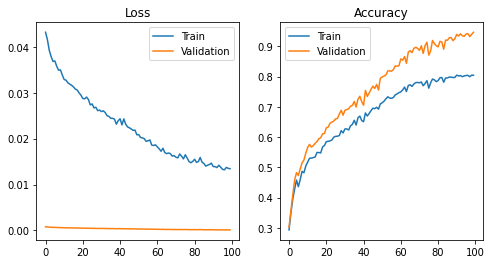

In [14]:
train_and_evaluate(cnn_lstm, cnn_lstm_optimizer, data_loaders_wgan, num_epochs=EPOCHS)

## CNN+GRU

Training Progress: 	Epoch 1 [0/8883 (0.00%)]		Loss: 1.49631
Training Progress: 	Epoch 1 [320/8883 (3.60%)]		Loss: 1.34690
Training Progress: 	Epoch 1 [640/8883 (7.19%)]		Loss: 1.40287
Training Progress: 	Epoch 1 [960/8883 (10.79%)]		Loss: 1.48454
Training Progress: 	Epoch 1 [1280/8883 (14.39%)]		Loss: 1.41889
Training Progress: 	Epoch 1 [1600/8883 (17.99%)]		Loss: 1.45936
Training Progress: 	Epoch 1 [1920/8883 (21.58%)]		Loss: 1.42860
Training Progress: 	Epoch 1 [2240/8883 (25.18%)]		Loss: 1.42542
Training Progress: 	Epoch 1 [2560/8883 (28.78%)]		Loss: 1.39264
Training Progress: 	Epoch 1 [2880/8883 (32.37%)]		Loss: 1.40555
Training Progress: 	Epoch 1 [3200/8883 (35.97%)]		Loss: 1.41193
Training Progress: 	Epoch 1 [3520/8883 (39.57%)]		Loss: 1.40208
Training Progress: 	Epoch 1 [3840/8883 (43.17%)]		Loss: 1.36866
Training Progress: 	Epoch 1 [4160/8883 (46.76%)]		Loss: 1.35985
Training Progress: 	Epoch 1 [4480/8883 (50.36%)]		Loss: 1.39293
Training Progress: 	Epoch 1 [4800/8883 (53.96%)]	

Training Progress: 	Epoch 5 [2240/8883 (25.18%)]		Loss: 1.20684
Training Progress: 	Epoch 5 [2560/8883 (28.78%)]		Loss: 1.32167
Training Progress: 	Epoch 5 [2880/8883 (32.37%)]		Loss: 1.29425
Training Progress: 	Epoch 5 [3200/8883 (35.97%)]		Loss: 1.21470
Training Progress: 	Epoch 5 [3520/8883 (39.57%)]		Loss: 1.30678
Training Progress: 	Epoch 5 [3840/8883 (43.17%)]		Loss: 1.35776
Training Progress: 	Epoch 5 [4160/8883 (46.76%)]		Loss: 1.32851
Training Progress: 	Epoch 5 [4480/8883 (50.36%)]		Loss: 1.20350
Training Progress: 	Epoch 5 [4800/8883 (53.96%)]		Loss: 1.21200
Training Progress: 	Epoch 5 [5120/8883 (57.55%)]		Loss: 1.21690
Training Progress: 	Epoch 5 [5440/8883 (61.15%)]		Loss: 1.30900
Training Progress: 	Epoch 5 [5760/8883 (64.75%)]		Loss: 1.29076
Training Progress: 	Epoch 5 [6080/8883 (68.35%)]		Loss: 1.15065
Training Progress: 	Epoch 5 [6400/8883 (71.94%)]		Loss: 1.20438
Training Progress: 	Epoch 5 [6720/8883 (75.54%)]		Loss: 1.23684
Training Progress: 	Epoch 5 [7040/8883 (

Training Progress: 	Epoch 9 [4480/8883 (50.36%)]		Loss: 1.09185
Training Progress: 	Epoch 9 [4800/8883 (53.96%)]		Loss: 1.11330
Training Progress: 	Epoch 9 [5120/8883 (57.55%)]		Loss: 1.25256
Training Progress: 	Epoch 9 [5440/8883 (61.15%)]		Loss: 1.25540
Training Progress: 	Epoch 9 [5760/8883 (64.75%)]		Loss: 1.20709
Training Progress: 	Epoch 9 [6080/8883 (68.35%)]		Loss: 1.07337
Training Progress: 	Epoch 9 [6400/8883 (71.94%)]		Loss: 1.22966
Training Progress: 	Epoch 9 [6720/8883 (75.54%)]		Loss: 1.24703
Training Progress: 	Epoch 9 [7040/8883 (79.14%)]		Loss: 1.20143
Training Progress: 	Epoch 9 [7360/8883 (82.73%)]		Loss: 1.36128
Training Progress: 	Epoch 9 [7680/8883 (86.33%)]		Loss: 1.14060
Training Progress: 	Epoch 9 [8000/8883 (89.93%)]		Loss: 1.32709
Training Progress: 	Epoch 9 [8320/8883 (93.53%)]		Loss: 1.07288
Training Progress: 	Epoch 9 [8640/8883 (97.12%)]		Loss: 1.26018
	Train loss: 0.03488, Accuracy: 4229/8883 (47.00%)
	Validation loss: 0.00063, Accuracy: 912/1692 (53.00%

Training Progress: 	Epoch 13 [6400/8883 (71.94%)]		Loss: 1.18333
Training Progress: 	Epoch 13 [6720/8883 (75.54%)]		Loss: 1.11199
Training Progress: 	Epoch 13 [7040/8883 (79.14%)]		Loss: 1.09567
Training Progress: 	Epoch 13 [7360/8883 (82.73%)]		Loss: 1.09741
Training Progress: 	Epoch 13 [7680/8883 (86.33%)]		Loss: 1.10560
Training Progress: 	Epoch 13 [8000/8883 (89.93%)]		Loss: 1.18118
Training Progress: 	Epoch 13 [8320/8883 (93.53%)]		Loss: 1.02012
Training Progress: 	Epoch 13 [8640/8883 (97.12%)]		Loss: 1.16027
	Train loss: 0.03276, Accuracy: 4550/8883 (51.00%)
	Validation loss: 0.00059, Accuracy: 925/1692 (54.00%)
	Test loss: 0.00064, Accuracy: 831/1772 (46.00%)

Training Progress: 	Epoch 14 [0/8883 (0.00%)]		Loss: 1.05813
Training Progress: 	Epoch 14 [320/8883 (3.60%)]		Loss: 1.10718
Training Progress: 	Epoch 14 [640/8883 (7.19%)]		Loss: 1.12838
Training Progress: 	Epoch 14 [960/8883 (10.79%)]		Loss: 1.15083
Training Progress: 	Epoch 14 [1280/8883 (14.39%)]		Loss: 1.15961
Training

Training Progress: 	Epoch 17 [8000/8883 (89.93%)]		Loss: 1.07988
Training Progress: 	Epoch 17 [8320/8883 (93.53%)]		Loss: 1.03793
Training Progress: 	Epoch 17 [8640/8883 (97.12%)]		Loss: 1.15060
	Train loss: 0.03140, Accuracy: 4754/8883 (53.00%)
	Validation loss: 0.00056, Accuracy: 971/1692 (57.00%)
	Test loss: 0.00062, Accuracy: 869/1772 (49.00%)

Training Progress: 	Epoch 18 [0/8883 (0.00%)]		Loss: 1.08364
Training Progress: 	Epoch 18 [320/8883 (3.60%)]		Loss: 1.16916
Training Progress: 	Epoch 18 [640/8883 (7.19%)]		Loss: 1.14200
Training Progress: 	Epoch 18 [960/8883 (10.79%)]		Loss: 1.07958
Training Progress: 	Epoch 18 [1280/8883 (14.39%)]		Loss: 1.18894
Training Progress: 	Epoch 18 [1600/8883 (17.99%)]		Loss: 1.32153
Training Progress: 	Epoch 18 [1920/8883 (21.58%)]		Loss: 1.25581
Training Progress: 	Epoch 18 [2240/8883 (25.18%)]		Loss: 1.18357
Training Progress: 	Epoch 18 [2560/8883 (28.78%)]		Loss: 1.18251
Training Progress: 	Epoch 18 [2880/8883 (32.37%)]		Loss: 1.19455
Training

Training Progress: 	Epoch 22 [0/8883 (0.00%)]		Loss: 1.01448
Training Progress: 	Epoch 22 [320/8883 (3.60%)]		Loss: 1.03078
Training Progress: 	Epoch 22 [640/8883 (7.19%)]		Loss: 1.17182
Training Progress: 	Epoch 22 [960/8883 (10.79%)]		Loss: 1.18845
Training Progress: 	Epoch 22 [1280/8883 (14.39%)]		Loss: 1.10238
Training Progress: 	Epoch 22 [1600/8883 (17.99%)]		Loss: 1.16753
Training Progress: 	Epoch 22 [1920/8883 (21.58%)]		Loss: 1.27822
Training Progress: 	Epoch 22 [2240/8883 (25.18%)]		Loss: 1.14512
Training Progress: 	Epoch 22 [2560/8883 (28.78%)]		Loss: 1.11883
Training Progress: 	Epoch 22 [2880/8883 (32.37%)]		Loss: 1.21889
Training Progress: 	Epoch 22 [3200/8883 (35.97%)]		Loss: 1.33263
Training Progress: 	Epoch 22 [3520/8883 (39.57%)]		Loss: 1.21630
Training Progress: 	Epoch 22 [3840/8883 (43.17%)]		Loss: 1.42037
Training Progress: 	Epoch 22 [4160/8883 (46.76%)]		Loss: 1.18895
Training Progress: 	Epoch 22 [4480/8883 (50.36%)]		Loss: 0.98221
Training Progress: 	Epoch 22 [4800

Training Progress: 	Epoch 26 [1920/8883 (21.58%)]		Loss: 1.05252
Training Progress: 	Epoch 26 [2240/8883 (25.18%)]		Loss: 1.04434
Training Progress: 	Epoch 26 [2560/8883 (28.78%)]		Loss: 1.10916
Training Progress: 	Epoch 26 [2880/8883 (32.37%)]		Loss: 1.15240
Training Progress: 	Epoch 26 [3200/8883 (35.97%)]		Loss: 1.10714
Training Progress: 	Epoch 26 [3520/8883 (39.57%)]		Loss: 1.31672
Training Progress: 	Epoch 26 [3840/8883 (43.17%)]		Loss: 1.35186
Training Progress: 	Epoch 26 [4160/8883 (46.76%)]		Loss: 1.18811
Training Progress: 	Epoch 26 [4480/8883 (50.36%)]		Loss: 0.93316
Training Progress: 	Epoch 26 [4800/8883 (53.96%)]		Loss: 0.93742
Training Progress: 	Epoch 26 [5120/8883 (57.55%)]		Loss: 1.23757
Training Progress: 	Epoch 26 [5440/8883 (61.15%)]		Loss: 1.34409
Training Progress: 	Epoch 26 [5760/8883 (64.75%)]		Loss: 1.11951
Training Progress: 	Epoch 26 [6080/8883 (68.35%)]		Loss: 0.97633
Training Progress: 	Epoch 26 [6400/8883 (71.94%)]		Loss: 1.02385
Training Progress: 	Epoch

Training Progress: 	Epoch 30 [3520/8883 (39.57%)]		Loss: 1.27413
Training Progress: 	Epoch 30 [3840/8883 (43.17%)]		Loss: 1.23129
Training Progress: 	Epoch 30 [4160/8883 (46.76%)]		Loss: 0.95111
Training Progress: 	Epoch 30 [4480/8883 (50.36%)]		Loss: 1.00138
Training Progress: 	Epoch 30 [4800/8883 (53.96%)]		Loss: 0.96210
Training Progress: 	Epoch 30 [5120/8883 (57.55%)]		Loss: 1.12679
Training Progress: 	Epoch 30 [5440/8883 (61.15%)]		Loss: 1.22687
Training Progress: 	Epoch 30 [5760/8883 (64.75%)]		Loss: 1.01158
Training Progress: 	Epoch 30 [6080/8883 (68.35%)]		Loss: 0.90554
Training Progress: 	Epoch 30 [6400/8883 (71.94%)]		Loss: 0.99538
Training Progress: 	Epoch 30 [6720/8883 (75.54%)]		Loss: 1.05735
Training Progress: 	Epoch 30 [7040/8883 (79.14%)]		Loss: 0.84190
Training Progress: 	Epoch 30 [7360/8883 (82.73%)]		Loss: 1.10103
Training Progress: 	Epoch 30 [7680/8883 (86.33%)]		Loss: 1.13484
Training Progress: 	Epoch 30 [8000/8883 (89.93%)]		Loss: 1.09571
Training Progress: 	Epoch

Training Progress: 	Epoch 34 [5120/8883 (57.55%)]		Loss: 1.08786
Training Progress: 	Epoch 34 [5440/8883 (61.15%)]		Loss: 1.21033
Training Progress: 	Epoch 34 [5760/8883 (64.75%)]		Loss: 1.21139
Training Progress: 	Epoch 34 [6080/8883 (68.35%)]		Loss: 0.96498
Training Progress: 	Epoch 34 [6400/8883 (71.94%)]		Loss: 0.89670
Training Progress: 	Epoch 34 [6720/8883 (75.54%)]		Loss: 1.19122
Training Progress: 	Epoch 34 [7040/8883 (79.14%)]		Loss: 1.03602
Training Progress: 	Epoch 34 [7360/8883 (82.73%)]		Loss: 1.26906
Training Progress: 	Epoch 34 [7680/8883 (86.33%)]		Loss: 0.94713
Training Progress: 	Epoch 34 [8000/8883 (89.93%)]		Loss: 0.97452
Training Progress: 	Epoch 34 [8320/8883 (93.53%)]		Loss: 1.06536
Training Progress: 	Epoch 34 [8640/8883 (97.12%)]		Loss: 1.14797
	Train loss: 0.02535, Accuracy: 5682/8883 (63.00%)
	Validation loss: 0.00043, Accuracy: 1192/1692 (70.00%)
	Test loss: 0.00062, Accuracy: 941/1772 (53.00%)

Training Progress: 	Epoch 35 [0/8883 (0.00%)]		Loss: 0.95358
Tr

Training Progress: 	Epoch 38 [6720/8883 (75.54%)]		Loss: 0.94026
Training Progress: 	Epoch 38 [7040/8883 (79.14%)]		Loss: 0.95242
Training Progress: 	Epoch 38 [7360/8883 (82.73%)]		Loss: 0.95746
Training Progress: 	Epoch 38 [7680/8883 (86.33%)]		Loss: 0.97402
Training Progress: 	Epoch 38 [8000/8883 (89.93%)]		Loss: 1.24543
Training Progress: 	Epoch 38 [8320/8883 (93.53%)]		Loss: 0.88527
Training Progress: 	Epoch 38 [8640/8883 (97.12%)]		Loss: 1.04975
	Train loss: 0.02460, Accuracy: 5917/8883 (66.00%)
	Validation loss: 0.00041, Accuracy: 1242/1692 (73.00%)
	Test loss: 0.00062, Accuracy: 932/1772 (52.00%)

Training Progress: 	Epoch 39 [0/8883 (0.00%)]		Loss: 1.01395
Training Progress: 	Epoch 39 [320/8883 (3.60%)]		Loss: 0.78659
Training Progress: 	Epoch 39 [640/8883 (7.19%)]		Loss: 0.97772
Training Progress: 	Epoch 39 [960/8883 (10.79%)]		Loss: 0.96769
Training Progress: 	Epoch 39 [1280/8883 (14.39%)]		Loss: 1.02498
Training Progress: 	Epoch 39 [1600/8883 (17.99%)]		Loss: 1.07448
Trainin

Training Progress: 	Epoch 42 [8320/8883 (93.53%)]		Loss: 0.97016
Training Progress: 	Epoch 42 [8640/8883 (97.12%)]		Loss: 1.02488
	Train loss: 0.02258, Accuracy: 6032/8883 (67.00%)
	Validation loss: 0.00037, Accuracy: 1265/1692 (74.00%)
	Test loss: 0.00062, Accuracy: 949/1772 (53.00%)

Training Progress: 	Epoch 43 [0/8883 (0.00%)]		Loss: 1.00908
Training Progress: 	Epoch 43 [320/8883 (3.60%)]		Loss: 0.95330
Training Progress: 	Epoch 43 [640/8883 (7.19%)]		Loss: 0.96285
Training Progress: 	Epoch 43 [960/8883 (10.79%)]		Loss: 0.93575
Training Progress: 	Epoch 43 [1280/8883 (14.39%)]		Loss: 0.93523
Training Progress: 	Epoch 43 [1600/8883 (17.99%)]		Loss: 1.06046
Training Progress: 	Epoch 43 [1920/8883 (21.58%)]		Loss: 1.11792
Training Progress: 	Epoch 43 [2240/8883 (25.18%)]		Loss: 0.94800
Training Progress: 	Epoch 43 [2560/8883 (28.78%)]		Loss: 0.90375
Training Progress: 	Epoch 43 [2880/8883 (32.37%)]		Loss: 0.90369
Training Progress: 	Epoch 43 [3200/8883 (35.97%)]		Loss: 1.12282
Trainin

Training Progress: 	Epoch 47 [320/8883 (3.60%)]		Loss: 0.82745
Training Progress: 	Epoch 47 [640/8883 (7.19%)]		Loss: 0.88669
Training Progress: 	Epoch 47 [960/8883 (10.79%)]		Loss: 1.01806
Training Progress: 	Epoch 47 [1280/8883 (14.39%)]		Loss: 1.00869
Training Progress: 	Epoch 47 [1600/8883 (17.99%)]		Loss: 1.22028
Training Progress: 	Epoch 47 [1920/8883 (21.58%)]		Loss: 1.07038
Training Progress: 	Epoch 47 [2240/8883 (25.18%)]		Loss: 0.88244
Training Progress: 	Epoch 47 [2560/8883 (28.78%)]		Loss: 0.93245
Training Progress: 	Epoch 47 [2880/8883 (32.37%)]		Loss: 1.02621
Training Progress: 	Epoch 47 [3200/8883 (35.97%)]		Loss: 0.97188
Training Progress: 	Epoch 47 [3520/8883 (39.57%)]		Loss: 1.08135
Training Progress: 	Epoch 47 [3840/8883 (43.17%)]		Loss: 1.04814
Training Progress: 	Epoch 47 [4160/8883 (46.76%)]		Loss: 1.07326
Training Progress: 	Epoch 47 [4480/8883 (50.36%)]		Loss: 0.76413
Training Progress: 	Epoch 47 [4800/8883 (53.96%)]		Loss: 0.80440
Training Progress: 	Epoch 47 [

Training Progress: 	Epoch 51 [2240/8883 (25.18%)]		Loss: 0.85345
Training Progress: 	Epoch 51 [2560/8883 (28.78%)]		Loss: 0.82787
Training Progress: 	Epoch 51 [2880/8883 (32.37%)]		Loss: 0.96051
Training Progress: 	Epoch 51 [3200/8883 (35.97%)]		Loss: 1.06063
Training Progress: 	Epoch 51 [3520/8883 (39.57%)]		Loss: 1.00789
Training Progress: 	Epoch 51 [3840/8883 (43.17%)]		Loss: 1.08655
Training Progress: 	Epoch 51 [4160/8883 (46.76%)]		Loss: 0.84672
Training Progress: 	Epoch 51 [4480/8883 (50.36%)]		Loss: 0.91440
Training Progress: 	Epoch 51 [4800/8883 (53.96%)]		Loss: 0.62120
Training Progress: 	Epoch 51 [5120/8883 (57.55%)]		Loss: 1.11930
Training Progress: 	Epoch 51 [5440/8883 (61.15%)]		Loss: 1.12230
Training Progress: 	Epoch 51 [5760/8883 (64.75%)]		Loss: 1.08040
Training Progress: 	Epoch 51 [6080/8883 (68.35%)]		Loss: 0.88837
Training Progress: 	Epoch 51 [6400/8883 (71.94%)]		Loss: 0.97283
Training Progress: 	Epoch 51 [6720/8883 (75.54%)]		Loss: 0.92779
Training Progress: 	Epoch

Training Progress: 	Epoch 55 [3840/8883 (43.17%)]		Loss: 1.02241
Training Progress: 	Epoch 55 [4160/8883 (46.76%)]		Loss: 0.77046
Training Progress: 	Epoch 55 [4480/8883 (50.36%)]		Loss: 0.67872
Training Progress: 	Epoch 55 [4800/8883 (53.96%)]		Loss: 0.86668
Training Progress: 	Epoch 55 [5120/8883 (57.55%)]		Loss: 1.21015
Training Progress: 	Epoch 55 [5440/8883 (61.15%)]		Loss: 1.07626
Training Progress: 	Epoch 55 [5760/8883 (64.75%)]		Loss: 1.22101
Training Progress: 	Epoch 55 [6080/8883 (68.35%)]		Loss: 0.80437
Training Progress: 	Epoch 55 [6400/8883 (71.94%)]		Loss: 1.29157
Training Progress: 	Epoch 55 [6720/8883 (75.54%)]		Loss: 0.85395
Training Progress: 	Epoch 55 [7040/8883 (79.14%)]		Loss: 0.79808
Training Progress: 	Epoch 55 [7360/8883 (82.73%)]		Loss: 0.81391
Training Progress: 	Epoch 55 [7680/8883 (86.33%)]		Loss: 0.81799
Training Progress: 	Epoch 55 [8000/8883 (89.93%)]		Loss: 1.05156
Training Progress: 	Epoch 55 [8320/8883 (93.53%)]		Loss: 0.82716
Training Progress: 	Epoch

Training Progress: 	Epoch 59 [5440/8883 (61.15%)]		Loss: 0.98332
Training Progress: 	Epoch 59 [5760/8883 (64.75%)]		Loss: 1.13442
Training Progress: 	Epoch 59 [6080/8883 (68.35%)]		Loss: 0.85860
Training Progress: 	Epoch 59 [6400/8883 (71.94%)]		Loss: 1.05407
Training Progress: 	Epoch 59 [6720/8883 (75.54%)]		Loss: 1.13486
Training Progress: 	Epoch 59 [7040/8883 (79.14%)]		Loss: 0.78483
Training Progress: 	Epoch 59 [7360/8883 (82.73%)]		Loss: 0.82849
Training Progress: 	Epoch 59 [7680/8883 (86.33%)]		Loss: 1.01606
Training Progress: 	Epoch 59 [8000/8883 (89.93%)]		Loss: 0.73366
Training Progress: 	Epoch 59 [8320/8883 (93.53%)]		Loss: 0.77295
Training Progress: 	Epoch 59 [8640/8883 (97.12%)]		Loss: 0.86002
	Train loss: 0.01859, Accuracy: 6662/8883 (74.00%)
	Validation loss: 0.00028, Accuracy: 1415/1692 (83.00%)
	Test loss: 0.00065, Accuracy: 980/1772 (55.00%)

Training Progress: 	Epoch 60 [0/8883 (0.00%)]		Loss: 0.97119
Training Progress: 	Epoch 60 [320/8883 (3.60%)]		Loss: 0.92645
Trai

Training Progress: 	Epoch 63 [7040/8883 (79.14%)]		Loss: 0.87197
Training Progress: 	Epoch 63 [7360/8883 (82.73%)]		Loss: 0.88379
Training Progress: 	Epoch 63 [7680/8883 (86.33%)]		Loss: 0.71587
Training Progress: 	Epoch 63 [8000/8883 (89.93%)]		Loss: 0.79922
Training Progress: 	Epoch 63 [8320/8883 (93.53%)]		Loss: 0.80996
Training Progress: 	Epoch 63 [8640/8883 (97.12%)]		Loss: 0.87031
	Train loss: 0.01693, Accuracy: 6900/8883 (77.00%)
	Validation loss: 0.00023, Accuracy: 1502/1692 (88.00%)
	Test loss: 0.00059, Accuracy: 1019/1772 (57.00%)

Training Progress: 	Epoch 64 [0/8883 (0.00%)]		Loss: 0.78187
Training Progress: 	Epoch 64 [320/8883 (3.60%)]		Loss: 0.70585
Training Progress: 	Epoch 64 [640/8883 (7.19%)]		Loss: 0.80094
Training Progress: 	Epoch 64 [960/8883 (10.79%)]		Loss: 0.93133
Training Progress: 	Epoch 64 [1280/8883 (14.39%)]		Loss: 0.92699
Training Progress: 	Epoch 64 [1600/8883 (17.99%)]		Loss: 0.91399
Training Progress: 	Epoch 64 [1920/8883 (21.58%)]		Loss: 0.96051
Traini

Training Progress: 	Epoch 67 [8640/8883 (97.12%)]		Loss: 0.81955
	Train loss: 0.01566, Accuracy: 6945/8883 (78.00%)
	Validation loss: 0.00020, Accuracy: 1522/1692 (89.00%)
	Test loss: 0.00060, Accuracy: 1020/1772 (57.00%)

Training Progress: 	Epoch 68 [0/8883 (0.00%)]		Loss: 0.74914
Training Progress: 	Epoch 68 [320/8883 (3.60%)]		Loss: 0.86427
Training Progress: 	Epoch 68 [640/8883 (7.19%)]		Loss: 0.85085
Training Progress: 	Epoch 68 [960/8883 (10.79%)]		Loss: 0.89854
Training Progress: 	Epoch 68 [1280/8883 (14.39%)]		Loss: 0.86510
Training Progress: 	Epoch 68 [1600/8883 (17.99%)]		Loss: 1.20165
Training Progress: 	Epoch 68 [1920/8883 (21.58%)]		Loss: 1.13673
Training Progress: 	Epoch 68 [2240/8883 (25.18%)]		Loss: 0.86735
Training Progress: 	Epoch 68 [2560/8883 (28.78%)]		Loss: 0.71859
Training Progress: 	Epoch 68 [2880/8883 (32.37%)]		Loss: 0.78503
Training Progress: 	Epoch 68 [3200/8883 (35.97%)]		Loss: 0.79852
Training Progress: 	Epoch 68 [3520/8883 (39.57%)]		Loss: 1.02127
Traini

Training Progress: 	Epoch 72 [640/8883 (7.19%)]		Loss: 0.72960
Training Progress: 	Epoch 72 [960/8883 (10.79%)]		Loss: 0.74757
Training Progress: 	Epoch 72 [1280/8883 (14.39%)]		Loss: 0.80411
Training Progress: 	Epoch 72 [1600/8883 (17.99%)]		Loss: 0.75100
Training Progress: 	Epoch 72 [1920/8883 (21.58%)]		Loss: 0.82103
Training Progress: 	Epoch 72 [2240/8883 (25.18%)]		Loss: 0.67320
Training Progress: 	Epoch 72 [2560/8883 (28.78%)]		Loss: 0.61924
Training Progress: 	Epoch 72 [2880/8883 (32.37%)]		Loss: 0.85786
Training Progress: 	Epoch 72 [3200/8883 (35.97%)]		Loss: 0.85992
Training Progress: 	Epoch 72 [3520/8883 (39.57%)]		Loss: 1.03463
Training Progress: 	Epoch 72 [3840/8883 (43.17%)]		Loss: 0.85072
Training Progress: 	Epoch 72 [4160/8883 (46.76%)]		Loss: 0.81173
Training Progress: 	Epoch 72 [4480/8883 (50.36%)]		Loss: 0.67430
Training Progress: 	Epoch 72 [4800/8883 (53.96%)]		Loss: 0.68844
Training Progress: 	Epoch 72 [5120/8883 (57.55%)]		Loss: 0.87267
Training Progress: 	Epoch 72

Training Progress: 	Epoch 76 [2240/8883 (25.18%)]		Loss: 0.77115
Training Progress: 	Epoch 76 [2560/8883 (28.78%)]		Loss: 0.70381
Training Progress: 	Epoch 76 [2880/8883 (32.37%)]		Loss: 0.74306
Training Progress: 	Epoch 76 [3200/8883 (35.97%)]		Loss: 0.91856
Training Progress: 	Epoch 76 [3520/8883 (39.57%)]		Loss: 0.91662
Training Progress: 	Epoch 76 [3840/8883 (43.17%)]		Loss: 0.93425
Training Progress: 	Epoch 76 [4160/8883 (46.76%)]		Loss: 0.81557
Training Progress: 	Epoch 76 [4480/8883 (50.36%)]		Loss: 0.63457
Training Progress: 	Epoch 76 [4800/8883 (53.96%)]		Loss: 0.71715
Training Progress: 	Epoch 76 [5120/8883 (57.55%)]		Loss: 1.15888
Training Progress: 	Epoch 76 [5440/8883 (61.15%)]		Loss: 1.01150
Training Progress: 	Epoch 76 [5760/8883 (64.75%)]		Loss: 0.66655
Training Progress: 	Epoch 76 [6080/8883 (68.35%)]		Loss: 0.72608
Training Progress: 	Epoch 76 [6400/8883 (71.94%)]		Loss: 0.87002
Training Progress: 	Epoch 76 [6720/8883 (75.54%)]		Loss: 0.76439
Training Progress: 	Epoch

Training Progress: 	Epoch 80 [3840/8883 (43.17%)]		Loss: 0.78756
Training Progress: 	Epoch 80 [4160/8883 (46.76%)]		Loss: 0.81850
Training Progress: 	Epoch 80 [4480/8883 (50.36%)]		Loss: 0.87232
Training Progress: 	Epoch 80 [4800/8883 (53.96%)]		Loss: 0.71968
Training Progress: 	Epoch 80 [5120/8883 (57.55%)]		Loss: 0.86574
Training Progress: 	Epoch 80 [5440/8883 (61.15%)]		Loss: 0.93458
Training Progress: 	Epoch 80 [5760/8883 (64.75%)]		Loss: 0.79094
Training Progress: 	Epoch 80 [6080/8883 (68.35%)]		Loss: 0.75713
Training Progress: 	Epoch 80 [6400/8883 (71.94%)]		Loss: 1.00782
Training Progress: 	Epoch 80 [6720/8883 (75.54%)]		Loss: 0.81859
Training Progress: 	Epoch 80 [7040/8883 (79.14%)]		Loss: 0.84065
Training Progress: 	Epoch 80 [7360/8883 (82.73%)]		Loss: 0.90823
Training Progress: 	Epoch 80 [7680/8883 (86.33%)]		Loss: 0.78005
Training Progress: 	Epoch 80 [8000/8883 (89.93%)]		Loss: 0.69247
Training Progress: 	Epoch 80 [8320/8883 (93.53%)]		Loss: 0.70109
Training Progress: 	Epoch

Training Progress: 	Epoch 84 [5440/8883 (61.15%)]		Loss: 0.90867
Training Progress: 	Epoch 84 [5760/8883 (64.75%)]		Loss: 0.87256
Training Progress: 	Epoch 84 [6080/8883 (68.35%)]		Loss: 0.67030
Training Progress: 	Epoch 84 [6400/8883 (71.94%)]		Loss: 0.87608
Training Progress: 	Epoch 84 [6720/8883 (75.54%)]		Loss: 0.80141
Training Progress: 	Epoch 84 [7040/8883 (79.14%)]		Loss: 0.83694
Training Progress: 	Epoch 84 [7360/8883 (82.73%)]		Loss: 0.78898
Training Progress: 	Epoch 84 [7680/8883 (86.33%)]		Loss: 0.54245
Training Progress: 	Epoch 84 [8000/8883 (89.93%)]		Loss: 0.62552
Training Progress: 	Epoch 84 [8320/8883 (93.53%)]		Loss: 0.59037
Training Progress: 	Epoch 84 [8640/8883 (97.12%)]		Loss: 0.65197
	Train loss: 0.01369, Accuracy: 7114/8883 (80.00%)
	Validation loss: 0.00014, Accuracy: 1578/1692 (93.00%)
	Test loss: 0.00060, Accuracy: 1078/1772 (60.00%)

Training Progress: 	Epoch 85 [0/8883 (0.00%)]		Loss: 0.64650
Training Progress: 	Epoch 85 [320/8883 (3.60%)]		Loss: 0.81584
Tra

Training Progress: 	Epoch 88 [7040/8883 (79.14%)]		Loss: 0.68454
Training Progress: 	Epoch 88 [7360/8883 (82.73%)]		Loss: 0.87588
Training Progress: 	Epoch 88 [7680/8883 (86.33%)]		Loss: 0.76488
Training Progress: 	Epoch 88 [8000/8883 (89.93%)]		Loss: 0.87782
Training Progress: 	Epoch 88 [8320/8883 (93.53%)]		Loss: 0.63954
Training Progress: 	Epoch 88 [8640/8883 (97.12%)]		Loss: 0.93262
	Train loss: 0.01345, Accuracy: 7188/8883 (80.00%)
	Validation loss: 0.00014, Accuracy: 1595/1692 (94.00%)
	Test loss: 0.00060, Accuracy: 1051/1772 (59.00%)

Training Progress: 	Epoch 89 [0/8883 (0.00%)]		Loss: 0.68327
Training Progress: 	Epoch 89 [320/8883 (3.60%)]		Loss: 0.67093
Training Progress: 	Epoch 89 [640/8883 (7.19%)]		Loss: 0.71874
Training Progress: 	Epoch 89 [960/8883 (10.79%)]		Loss: 0.67272
Training Progress: 	Epoch 89 [1280/8883 (14.39%)]		Loss: 0.82931
Training Progress: 	Epoch 89 [1600/8883 (17.99%)]		Loss: 0.90438
Training Progress: 	Epoch 89 [1920/8883 (21.58%)]		Loss: 0.82811
Traini

Training Progress: 	Epoch 92 [8640/8883 (97.12%)]		Loss: 0.93967
	Train loss: 0.01333, Accuracy: 7104/8883 (79.00%)
	Validation loss: 0.00013, Accuracy: 1561/1692 (92.00%)
	Test loss: 0.00065, Accuracy: 1059/1772 (59.00%)

Training Progress: 	Epoch 93 [0/8883 (0.00%)]		Loss: 0.68637
Training Progress: 	Epoch 93 [320/8883 (3.60%)]		Loss: 0.70940
Training Progress: 	Epoch 93 [640/8883 (7.19%)]		Loss: 0.50313
Training Progress: 	Epoch 93 [960/8883 (10.79%)]		Loss: 0.67459
Training Progress: 	Epoch 93 [1280/8883 (14.39%)]		Loss: 1.01568
Training Progress: 	Epoch 93 [1600/8883 (17.99%)]		Loss: 1.00628
Training Progress: 	Epoch 93 [1920/8883 (21.58%)]		Loss: 0.72227
Training Progress: 	Epoch 93 [2240/8883 (25.18%)]		Loss: 0.83520
Training Progress: 	Epoch 93 [2560/8883 (28.78%)]		Loss: 0.76712
Training Progress: 	Epoch 93 [2880/8883 (32.37%)]		Loss: 0.87016
Training Progress: 	Epoch 93 [3200/8883 (35.97%)]		Loss: 0.77181
Training Progress: 	Epoch 93 [3520/8883 (39.57%)]		Loss: 0.82533
Traini

Training Progress: 	Epoch 97 [640/8883 (7.19%)]		Loss: 0.83094
Training Progress: 	Epoch 97 [960/8883 (10.79%)]		Loss: 0.63430
Training Progress: 	Epoch 97 [1280/8883 (14.39%)]		Loss: 0.73771
Training Progress: 	Epoch 97 [1600/8883 (17.99%)]		Loss: 0.73405
Training Progress: 	Epoch 97 [1920/8883 (21.58%)]		Loss: 0.59671
Training Progress: 	Epoch 97 [2240/8883 (25.18%)]		Loss: 0.59758
Training Progress: 	Epoch 97 [2560/8883 (28.78%)]		Loss: 0.59257
Training Progress: 	Epoch 97 [2880/8883 (32.37%)]		Loss: 0.64288
Training Progress: 	Epoch 97 [3200/8883 (35.97%)]		Loss: 0.75842
Training Progress: 	Epoch 97 [3520/8883 (39.57%)]		Loss: 0.75112
Training Progress: 	Epoch 97 [3840/8883 (43.17%)]		Loss: 0.67461
Training Progress: 	Epoch 97 [4160/8883 (46.76%)]		Loss: 0.71283
Training Progress: 	Epoch 97 [4480/8883 (50.36%)]		Loss: 0.66324
Training Progress: 	Epoch 97 [4800/8883 (53.96%)]		Loss: 0.75096
Training Progress: 	Epoch 97 [5120/8883 (57.55%)]		Loss: 0.78857
Training Progress: 	Epoch 97

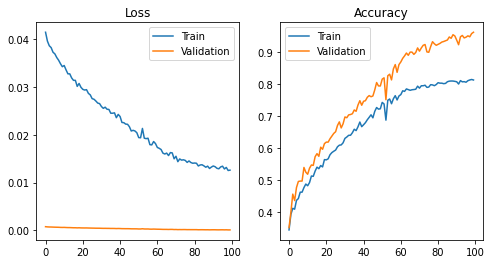

In [15]:
train_and_evaluate(cnn_gru, cnn_gru_optimizer, data_loaders_wgan, num_epochs=EPOCHS)